### Описание проекта. ###
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.  
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.  
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Таблица __market_file.csv__, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  
__id__ — номер покупателя в корпоративной базе данных.  
__Покупательская активность__ — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».      
__Тип сервиса__ — уровень сервиса, например «премиум» и «стандарт».  
__Разрешить сообщать__ — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.  
__Маркет_актив_6_мес__ — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.  
__Маркет_актив_тек_мес__ — количество маркетинговых коммуникаций в текущем месяце.  
__Длительность__ — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.  
__Акционные_покупки__ — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.  
__Популярная_категория__ — самая популярная категория товаров у покупателя за последние 6 месяцев.  
__Средний_просмотр_категорий_за_визит__ — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.  
__Неоплаченные_продукты_штук_квартал__ — общее число неоплаченных товаров в корзине за последние 3 месяца.  
__Ошибка_сервиса__ — число сбоев, которые коснулись покупателя во время посещения сайта.  
__Страниц_за_визит__ — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.  

Таблица __market_money__ с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
__id__ — номер покупателя в корпоративной базе данных.  
__Период__ — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.  
__Выручка__ — сумма выручки за период.  


Таблица __market_time.csv__ с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
__id__ — номер покупателя в корпоративной базе данных.  
__Период__ — название периода, во время которого зафиксировано общее время.  
__минут__ — значение времени, проведённого на сайте, в минутах.  

Таблица __money.csv__ с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.  
__id__ — номер покупателя в корпоративной базе данных.  
__Прибыль__ — значение прибыли.  

In [1]:
!pip install optuna -q
!pip install shap -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer 

import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.spatial.distance import euclidean, cityblock
from sklearn.model_selection import train_test_split, GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, RocCurveDisplay 

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from optuna import distributions
from optuna.integration import OptunaSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import shap

from sklearn import preprocessing
RANDOM_STATE = 42
TEST_SIZE = 0.25

## 1) Загрузка данных

In [4]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
df3 = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
df4 = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv',sep=';', decimal = ',')

df_market_file = df1.copy()
df_market_money = df2.copy()
df_market_time = df3.copy()
df_money = df4.copy()

In [5]:
def Load_info(df):
    display(df.describe().T)
    print('*'*50)
    display(df.head())
    print('*'*50)
    display(df.info())
    print('*'*50)
    print('Кол-во дубликатов : ',df.duplicated().sum())
    print('*'*50)

In [6]:
basa = [df_market_file,df_market_money,df_market_time,df_money]
for df in basa:
    Load_info(df)

,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


**************************************************


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non

None

**************************************************
Кол-во дубликатов :  0
**************************************************


,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


**************************************************


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


**************************************************


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


**************************************************


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

**************************************************
Кол-во дубликатов :  0
**************************************************


In [7]:
# Проверка на наличие пропущенных значений
basa = [df_market_file, df_market_money, df_market_time, df_money]
for df in basa:
    display(df.isna().sum())
    print('*'* 35)

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

***********************************


id         0
Период     0
Выручка    0
dtype: int64

***********************************


id        0
Период    0
минут     0
dtype: int64

***********************************


id         0
Прибыль    0
dtype: int64

***********************************


In [8]:
df_market_file['Тип сервиса'].value_counts()

Тип сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

In [9]:
#Удаляю еденичные выбросы
df_market_money = df_market_money[df_market_money['Выручка']!=106862.2]
df_market_money = df_market_money[df_market_money['Выручка']!=0]

In [10]:
df_market_file['Тип сервиса'] = df_market_file['Тип сервиса'].replace('стандартт','стандарт')
df_market_time['Период'] = df_market_time['Период'].replace('предыдцщий_месяц','предыдущий_месяц')


In [11]:
df_market_file = df_market_file.rename(columns={'Покупательская активность' : 'Покупательская_активность', 'Тип сервиса' : 'Тип_сервиса', 'Разрешить сообщать' : 'Разрешить_сообщать'})
df_market_time = df_market_time.rename(columns={'минут' : 'Минут'})

# 3 #

In [12]:
def plot_feature_distribution(df, feature):
    plt.figure(figsize=(10, 4))
    sns.histplot(data = df[feature], bins='auto', kde=True, multiple='dodge').set(title='График распределения ')
    #plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.show()

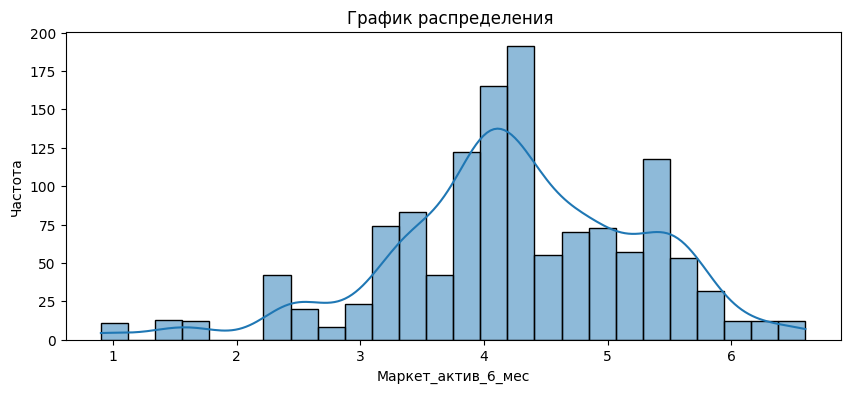

Максимальная значение маркетинговых коммуникаций за 6 месяцев колеблится в районе 4


In [13]:
plot_feature_distribution(df_market_file, 'Маркет_актив_6_мес')
print('Максимальная значение маркетинговых коммуникаций за 6 месяцев колеблится в районе 4')

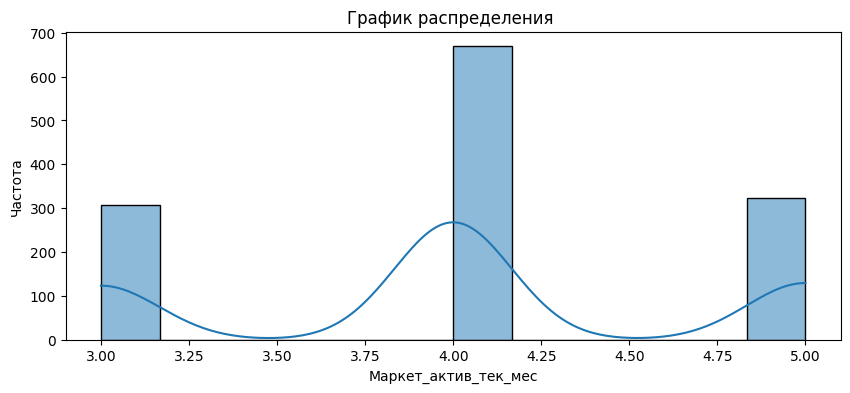

Максимальная значение маркетинговых комменикаций колеблится в районе 4


In [14]:
plot_feature_distribution(df_market_file, 'Маркет_актив_тек_мес')
print('Максимальная значение маркетинговых комменикаций колеблится в районе 4')

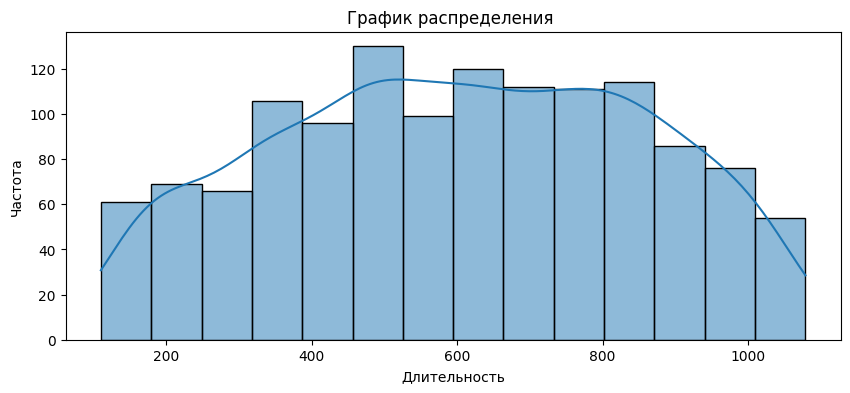

В последенне время количесво новых пользователей сокртилось и держится какоето время


In [15]:
plot_feature_distribution(df_market_file, 'Длительность')
print('В последенне время количесво новых пользователей сокртилось и держится какоето время')

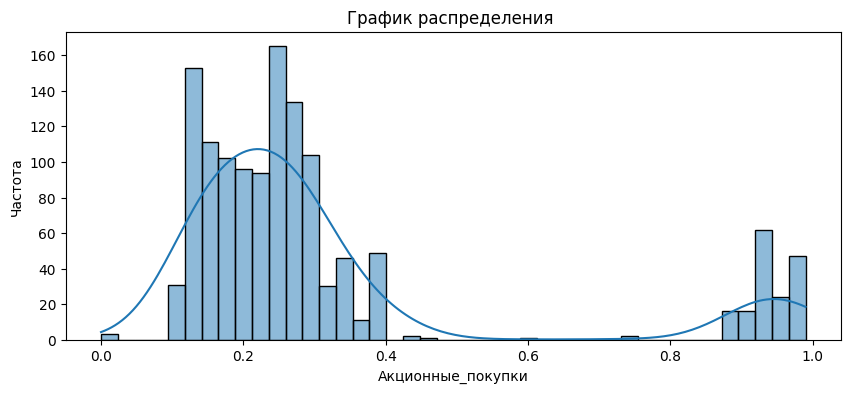

Максимальный инетерес вызывает каждая пятая акция, также не большой поцент кто покупает практически весь товар по акции, надо будит посмотеть из какой категорииэти люди


In [16]:
plot_feature_distribution(df_market_file, 'Акционные_покупки')
print('Максимальный инетерес вызывает каждая пятая акция, также не большой поцент кто покупает практически весь товар по акции, надо будит посмотеть из какой категорииэти люди')

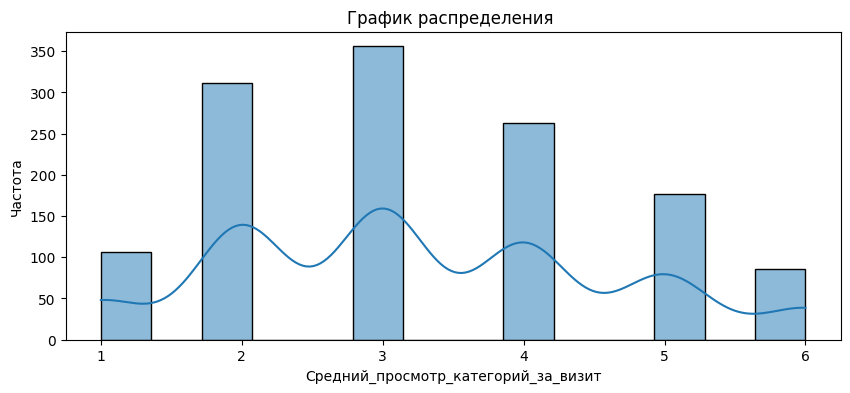

Вполне ожидемый результат в среденм человек посещает 3 +- 1 категория.


In [17]:
plot_feature_distribution(df_market_file, 'Средний_просмотр_категорий_за_визит')
print('Вполне ожидемый результат в среденм человек посещает 3 +- 1 категория.')

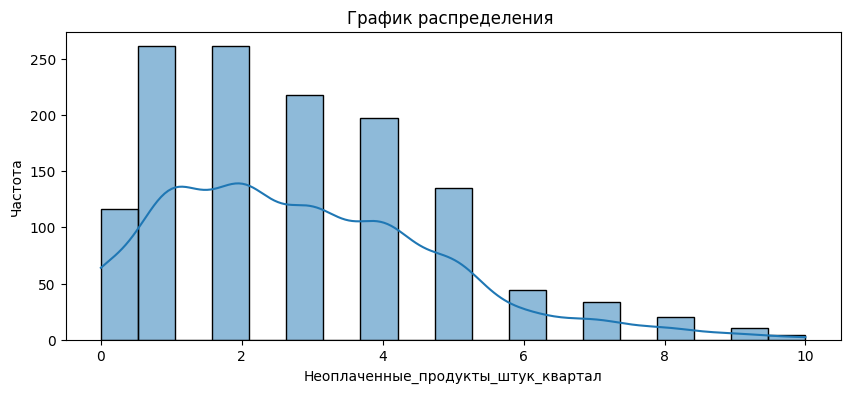

Один два товара ждут снижение цены в карзине, как правило


In [18]:
plot_feature_distribution(df_market_file, 'Неоплаченные_продукты_штук_квартал')
print('Один два товара ждут снижение цены в карзине, как правило')

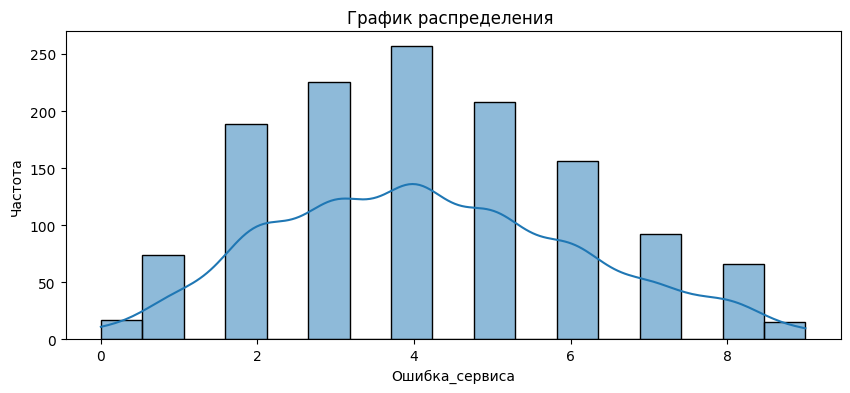

Надо выяснять чем обусловлено именно 4 ошибки сервиса


In [19]:
plot_feature_distribution(df_market_file, 'Ошибка_сервиса')
print('Надо выяснять чем обусловлено именно 4 ошибки сервиса')

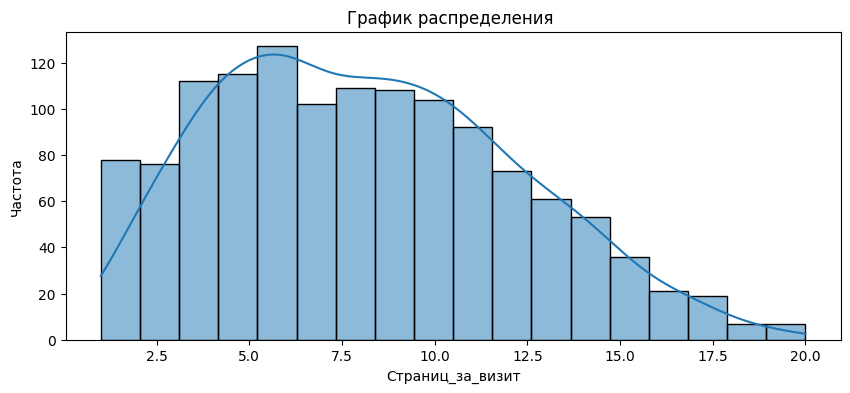

При поиске товара человек просматривает 3 до 11 страниц соотвественно если ходим повысить выручку ставим "рекомендованные" товары на страницах от 2 до 10


In [20]:
plot_feature_distribution(df_market_file, 'Страниц_за_визит')
print('При поиске товара человек просматривает 3 до 11 страниц соотвественно если ходим повысить выручку ставим "рекомендованные" товары на страницах от 2 до 10')

In [22]:
def plot_categorical_distribution(df, feature):
    df_for_hi = df.groupby(feature).size()/len(df)
    
    df_for_hi.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True, figsize=(20,5), 
                   title=feature,  wedgeprops={'linewidth':1, 'edgecolor':'white'})

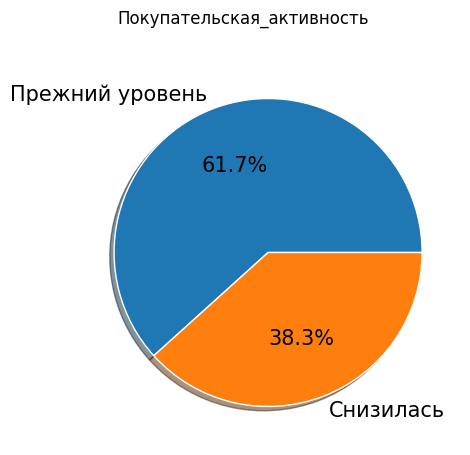

In [23]:
plot_categorical_distribution(df_market_file, 'Покупательская_активность')

Покупательская активнасть снизилась почти на 40%,  надо мотреть какие категории просели.

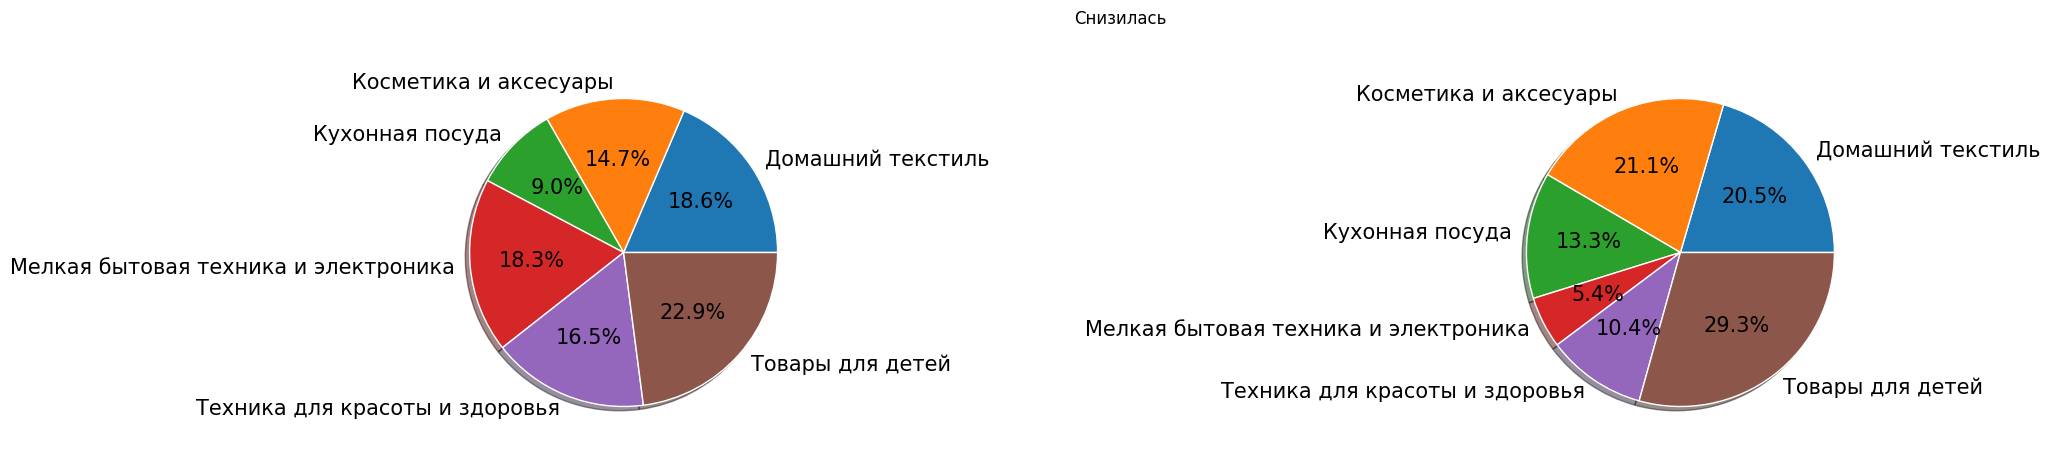

In [24]:
_, axes = plt.subplots(1, 2,  figsize=(25,5))

df = df_market_file.query('Покупательская_активность == "Прежний уровень"')

df_for_hi = df.groupby('Популярная_категория').size()/len(df)
df_for_hi.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True, figsize=(20,5), ax = axes[0], 
                   title='Прежний уровень',  wedgeprops={'linewidth':1, 'edgecolor':'white'})

df1 = df_market_file.query('Покупательская_активность == "Снизилась"')

df_for_hi1 = df1.groupby('Популярная_категория').size()/len(df)
df_for_hi1.plot(kind='pie', subplots=True, fontsize=15, autopct='%.1f%%', shadow=True, figsize=(20,5), ax = axes[1],
                   title='Снизилась',  wedgeprops={'linewidth':1, 'edgecolor':'white'})
pass


Просели следующии категории:  
1) __На первом месте "товары для детей"__
2) __"Домашний текстиль"__
3) __"Косметика и аксесуары"__
4) __"Техника для красоты и здоровья"__  
А вот категория которая меньше всего пострадала это __"Мелкая бытовая техника__ и электроника"


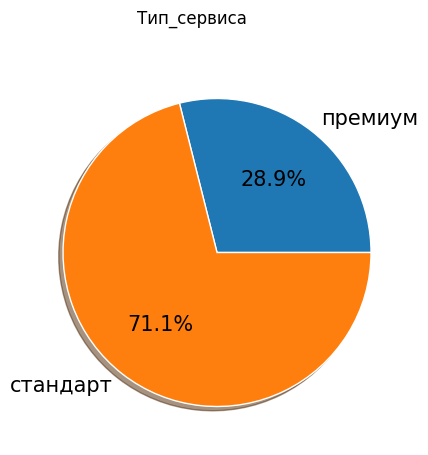

In [25]:
plot_categorical_distribution(df_market_file, 'Тип_сервиса')

Около 30% пользвателей пользуются сервисам премиум

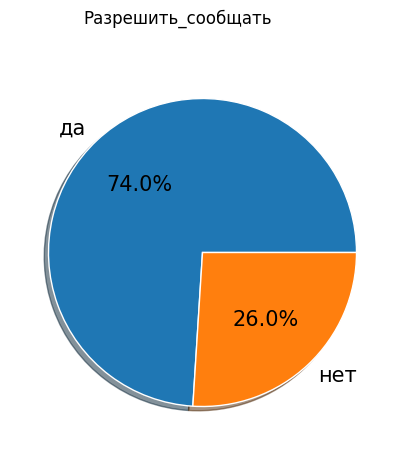

In [26]:
plot_categorical_distribution(df_market_file, 'Разрешить_сообщать')

Почти 75% людей лаялны (не плохой показатель)

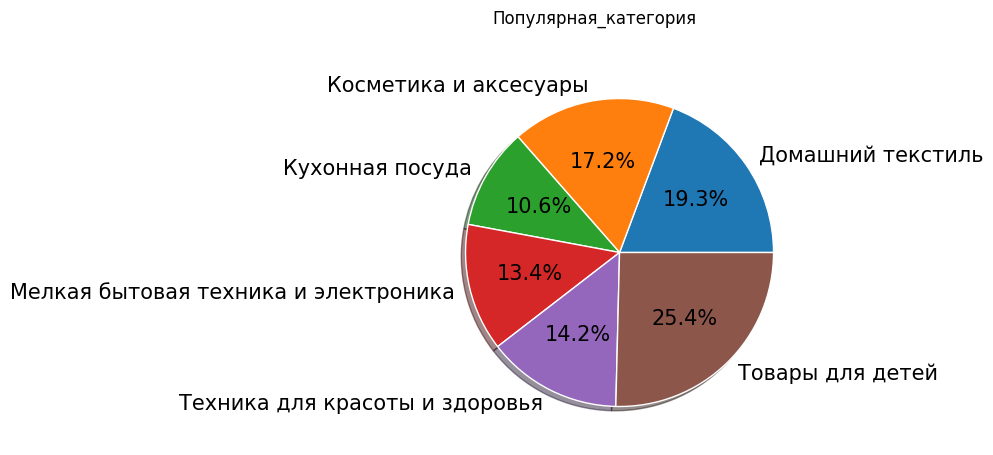

In [27]:
plot_categorical_distribution(df_market_file, 'Популярная_категория')

Наиболее популярные категрии можно отнести к так называемым женским. Товары для детей дома и косметика из чего напрашивается выводол что сновная доля покупателей это женщины.

### Исследование таблицы  __df_market_time__

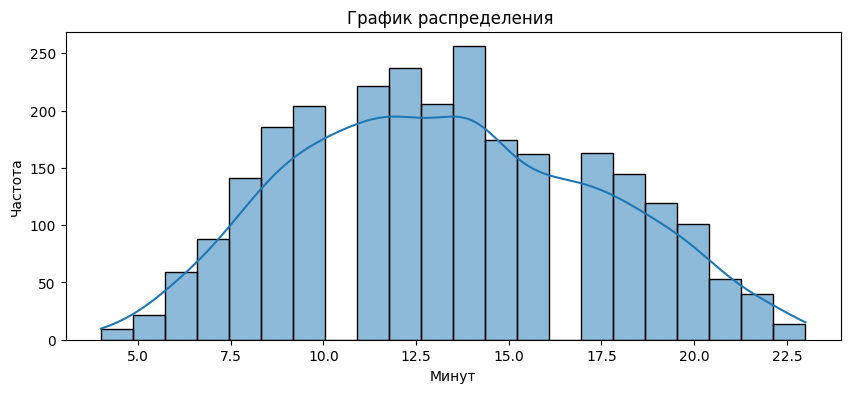

In [29]:
plot_feature_distribution(df_market_time, 'Минут')


__Вывод__ распределение можно считать условно номальным

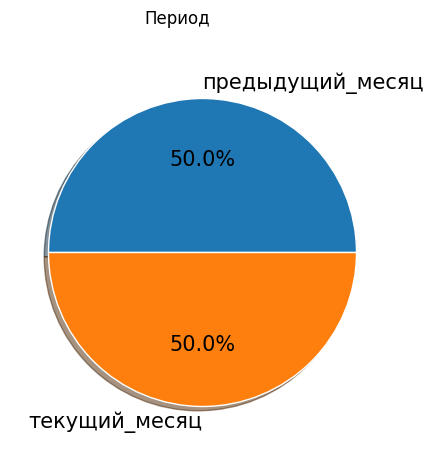

In [30]:
plot_categorical_distribution(df_market_time, 'Период')


__Вывод__ Все значения распределены равномерно

### Исследование таблицы  __df_market_money__

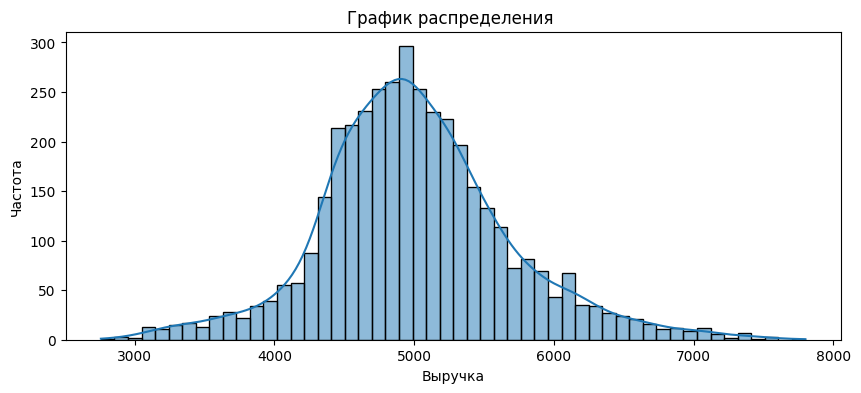

In [31]:
plot_feature_distribution(df_market_money, 'Выручка')

__Вывод__ Видим нормальное распределение.

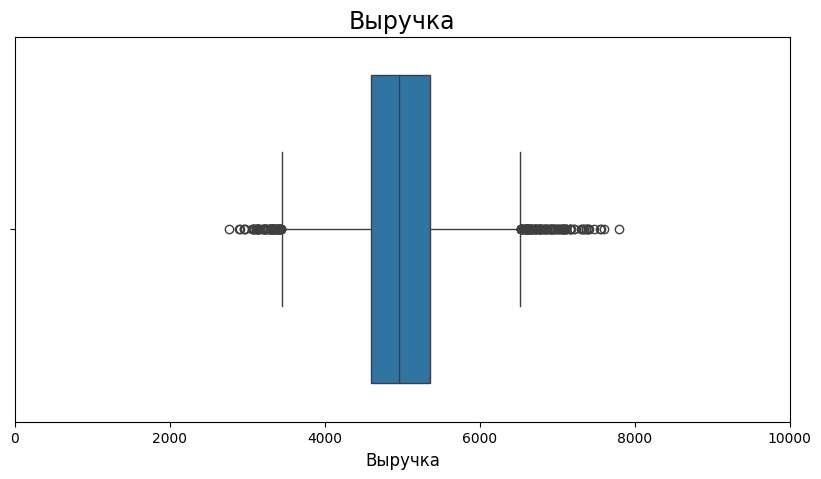

,count,mean,std,min,25%,50%,75%,max
id,3893.0,215998.649371,374.681667,215348.0,215674.0,215999.0,216323.0,216647.0
Выручка,3893.0,5007.282918,679.724898,2758.7,4592.0,4959.0,5363.0,7799.4


In [32]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_market_money, x='Выручка')
plt.xlim(0, 10000)
plt.title('Выручка', size=17)
plt.xlabel('Выручка', size=12)
plt.show()
df_market_money.describe().T

__Вывод__ Boxplot неплохо выглядит выбросы очень ровные распределение нормальное среднее значение коллеблится в районе 5000

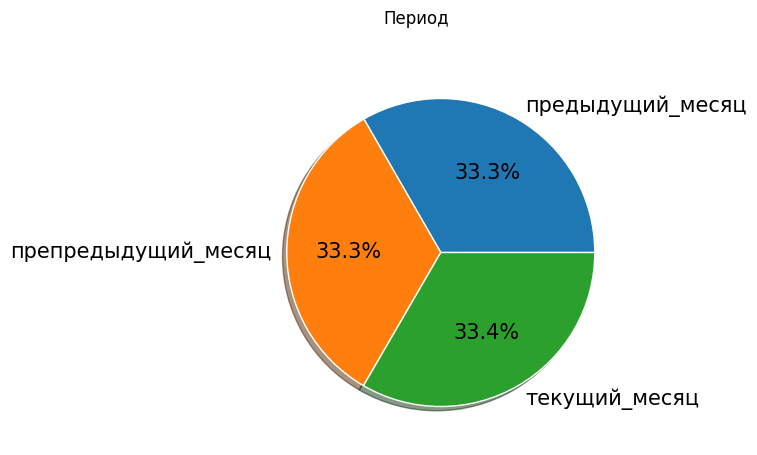

In [33]:
plot_categorical_distribution(df_market_money, 'Период')


Все значения распределены равномерно

In [34]:
df_three_month = df_market_money[(df_market_money['Период'] == 'препредыдущий_месяц') & (df_market_money['Выручка'] != 0.0)]['id']
df_three_month = pd.merge(df_market_file, df_three_month, on=['id'], how='inner')
df_three_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

# Шаг 4. Объединение таблиц #

Объеденяю таблицы так как это разовая процедура и много столбцов в присоеденяемых таблицах не вижу смылса писать функцию

In [35]:
test= df_three_month.copy()
test2 = df_market_money[df_market_money['Период']== 'текущий_месяц']

df = test.set_index('id') 
df_new = test2.set_index('id')

df_full = df.join(df_new)

df_full= df_full.drop(['Период'], axis=1)
df_full= df_full.rename(columns={'Выручка':'Tекущий_месяц_выр'})


test2 = df_market_money[df_market_money['Период']== 'препредыдущий_месяц']
df_new = test2.set_index('id')

df_full = df_full.join(df_new)

df_full= df_full.drop(['Период'], axis=1)
df_full= df_full.rename(columns={'Выручка':'Препредыдущий_месяц_выр'})


test2 = df_market_money[df_market_money['Период']== 'предыдущий_месяц']
df_new = test2.set_index('id')

df_full = df_full.join(df_new)

df_full= df_full.drop(['Период'], axis=1)
df_full= df_full.rename(columns={'Выручка':'Предыдущий_месяц_выр'})


test2 = df_market_time[df_market_time['Период']== 'текущий_месяц']
df_new = test2.set_index('id')

df_full = df_full.join(df_new)

df_full= df_full.drop(['Период'], axis=1)
df_full= df_full.rename(columns={'Минут':'Tекущий_месяц_мин'})


test2 = df_market_time[df_market_time['Период']== 'предыдущий_месяц']
df_new = test2.set_index('id')

df_full = df_full.join(df_new)

df_full= df_full.drop(['Период'], axis=1)
df_full= df_full.rename(columns={'Минут':'Предыдущий_месяц_мин'})

In [36]:
df_full.head().T

id,215349,215350,215351,215352,215353
Покупательская_активность,Снизилась,Снизилась,Снизилась,Снизилась,Снизилась
Тип_сервиса,премиум,стандарт,стандарт,стандарт,стандарт
Разрешить_сообщать,да,нет,да,нет,да
Маркет_актив_6_мес,4.4,4.9,3.2,5.1,3.3
Маркет_актив_тек_мес,4,3,5,3,4
Длительность,819,539,896,1064,762
Акционные_покупки,0.75,0.14,0.99,0.94,0.26
Популярная_категория,Товары для детей,Домашний текстиль,Товары для детей,Товары для детей,Домашний текстиль
Средний_просмотр_категорий_за_визит,4,5,5,3,4
Неоплаченные_продукты_штук_квартал,4,2,0,2,1


In [37]:
df_full.loc[df_full['Tекущий_месяц_выр'].isna(), 'Tекущий_месяц_выр']=df_full['Tекущий_месяц_выр'].mode()[0] # запоняем NaN модовым значением

In [38]:
def hist_plot(columns):
    
    _, axes = plt.subplots(1, 2, figsize=(25,5))
    plt.ylabel('Частота')
    df_full[df_full['Покупательская_активность'] == 'Прежний уровень'][columns].plot(kind='hist', ax = axes[0],edgecolor='black',
                                                                       grid=True,   
                                                                      title='Прежний уровень ', xlabel=columns)
    df_full[df_full['Покупательская_активность'] == 'Снизилась'][columns].plot(kind='hist', ax = axes[1],edgecolor='black',
                                                                       grid=True,   
                                                                      title='Снизилось',  color = 'green', xlabel=columns)                 
pass

In [39]:
#df_full.select_dtypes(exclude='object').columns.to_list()

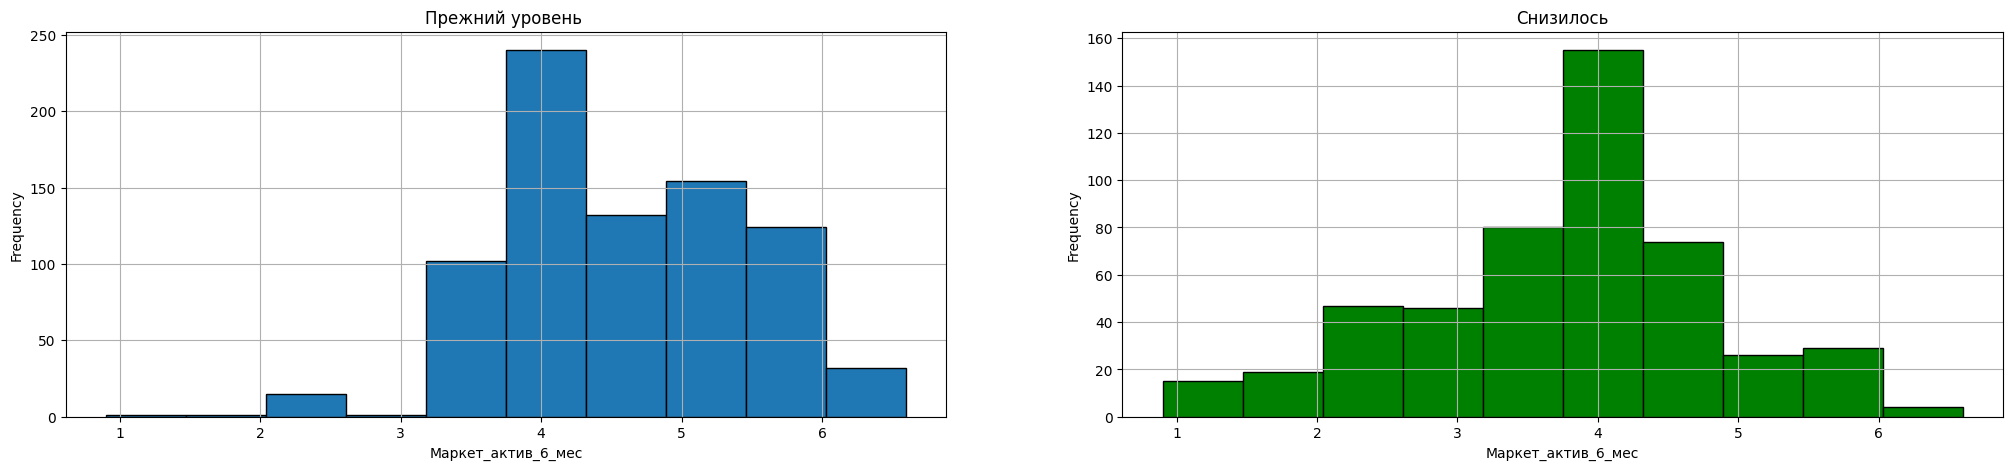

In [40]:
hist_plot('Маркет_актив_6_мес')


Ничего примечательного нет в среднем с обееми категориями взаимодействовали одинаково.

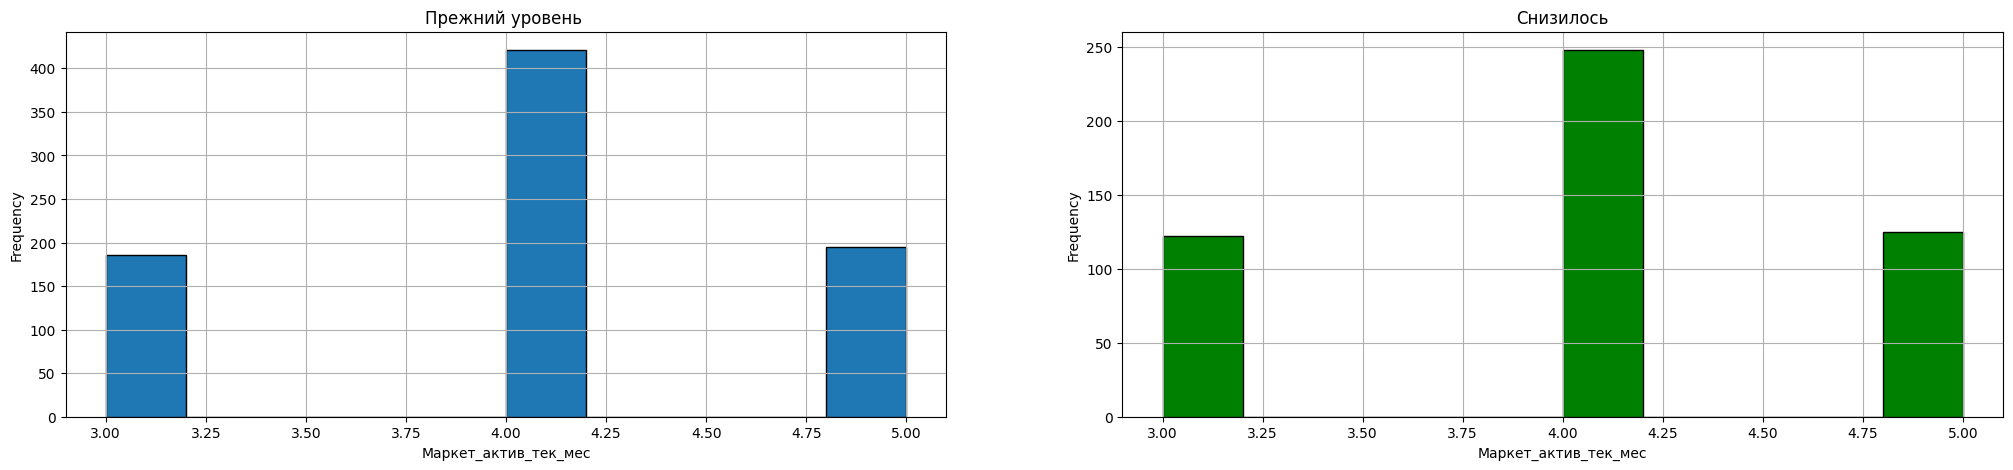

In [41]:
hist_plot('Маркет_актив_тек_мес')  

Ничего примечательного нет в среднем с обееми категориями взаимодействовали одинаково.

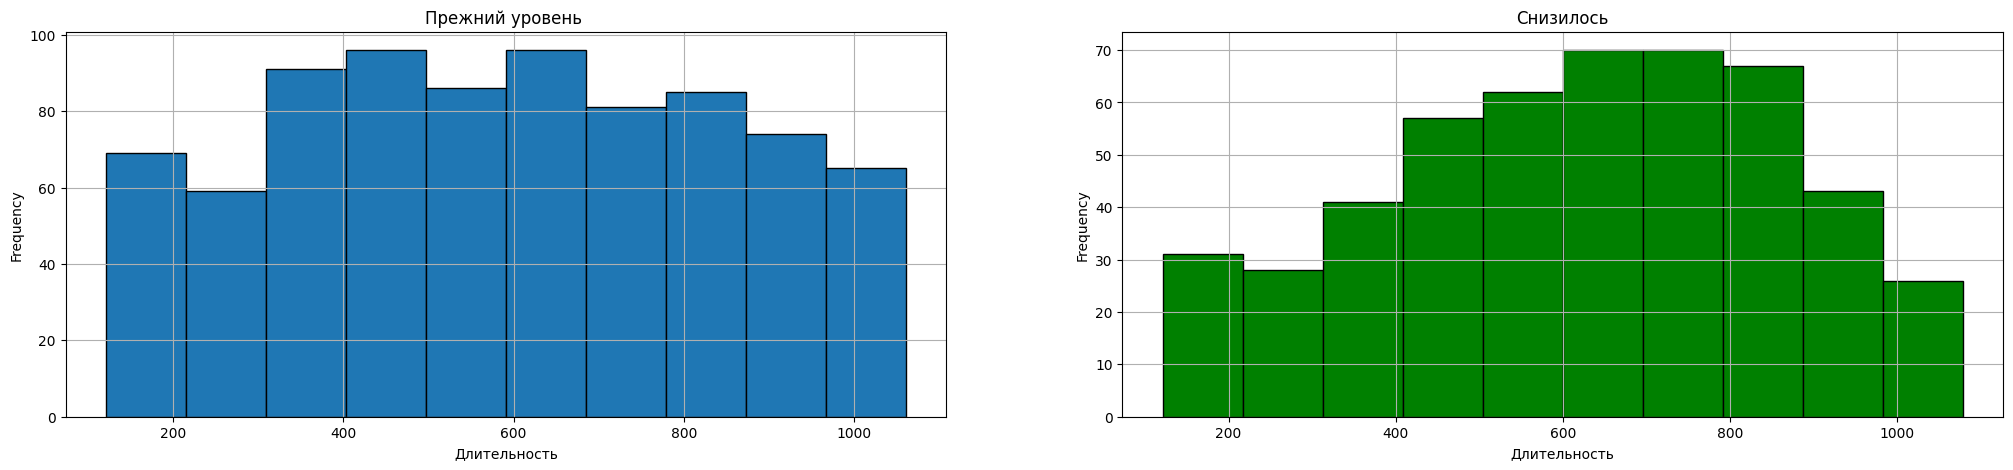

In [42]:
hist_plot('Длительность')  

Максимальный отток клиетнов можно отнести к "старичками", интересно почему не новые клиенты меньше покупают.

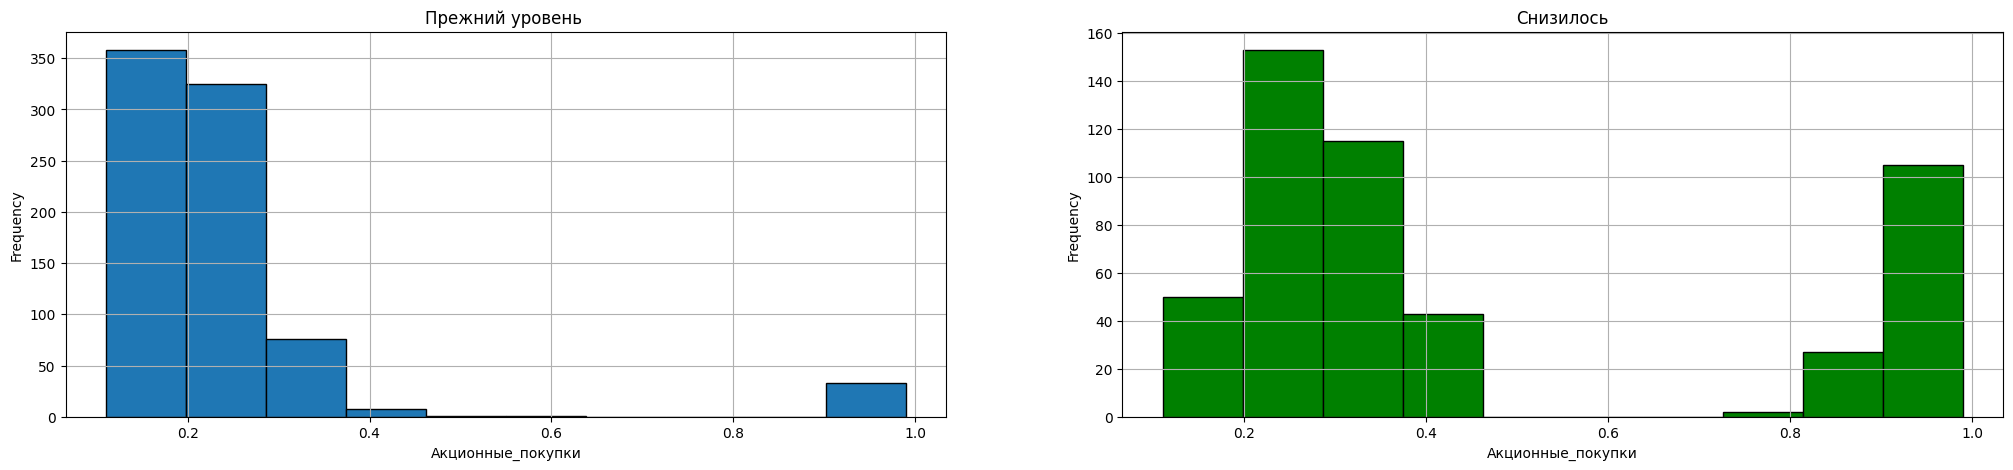

In [43]:
hist_plot('Акционные_покупки')  

Низкий процент покупки акционных товаров может быть связан с низкой эффективностью проводжимых акций. Какая-то чать клиентов у которых показатели снизелись скорее всего дождались акционнова товара и "отвалились"

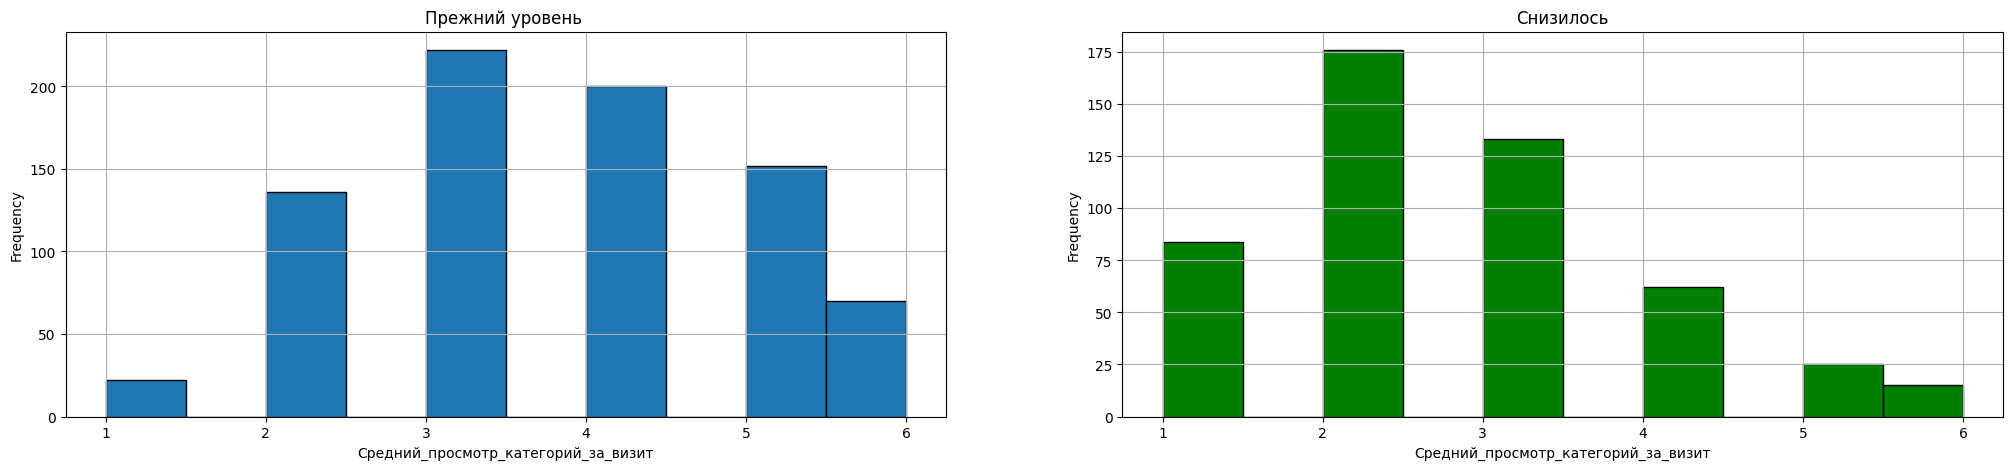

In [44]:
hist_plot('Средний_просмотр_категорий_за_визит')  

На "прежнем уровне" клиенты закалывают товары в 3-5 категориях, в то время клиетны категории "Снизилось" закалываеют только из 2-3 категорий.  
__Вывод__ Категория "Снизелось" целевые поиски товаров.

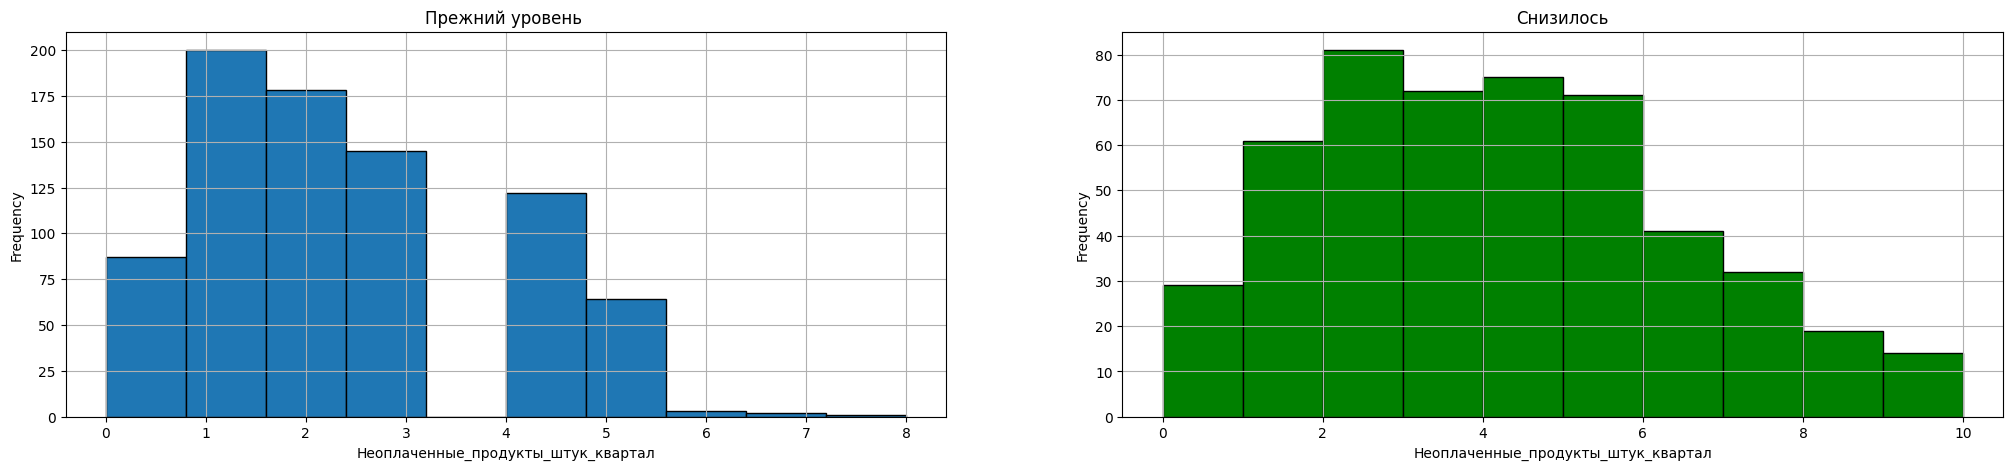

In [45]:
hist_plot('Неоплаченные_продукты_штук_квартал')  

Очень хорактерно категория "Снизилось" можно отнести к категории "ждуны", откладывают товар в корзину и ждут акции.

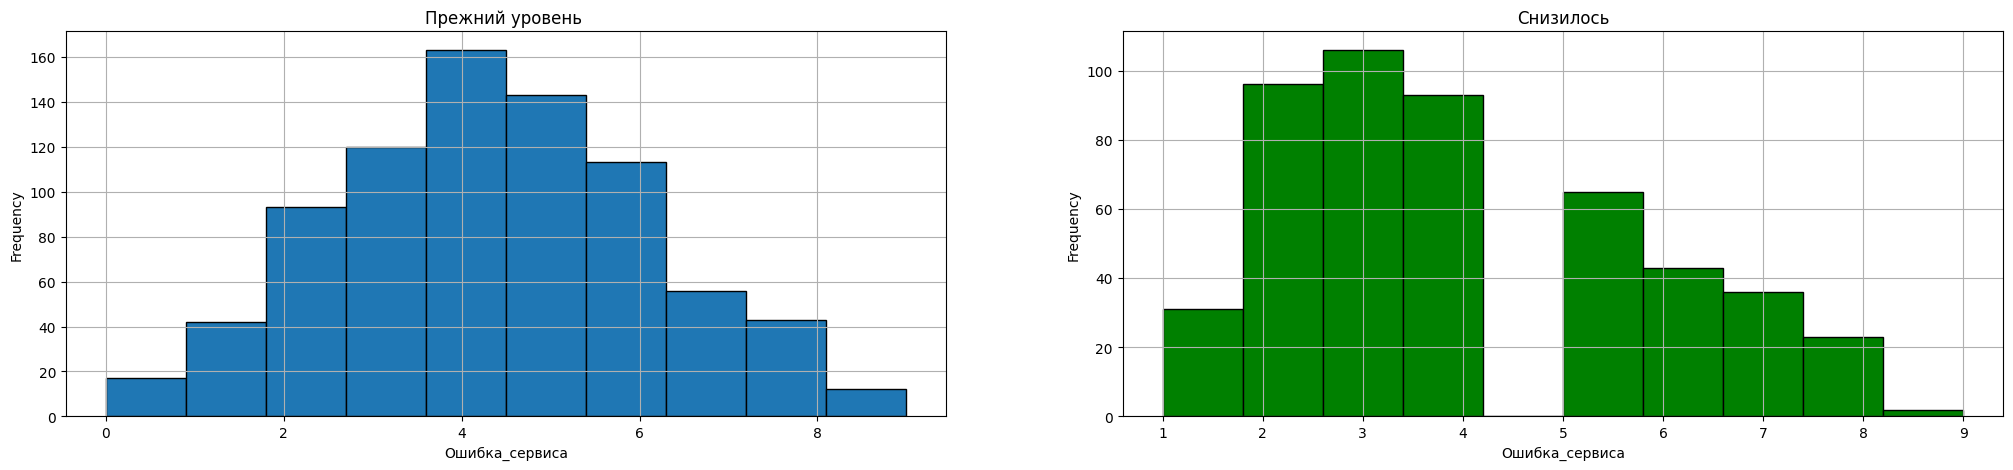

In [46]:
hist_plot('Ошибка_сервиса')  

Трудно что либо сказать неясна проблема сбоев но сказать что именно она влияет на снижение активности пользователей нельзя.

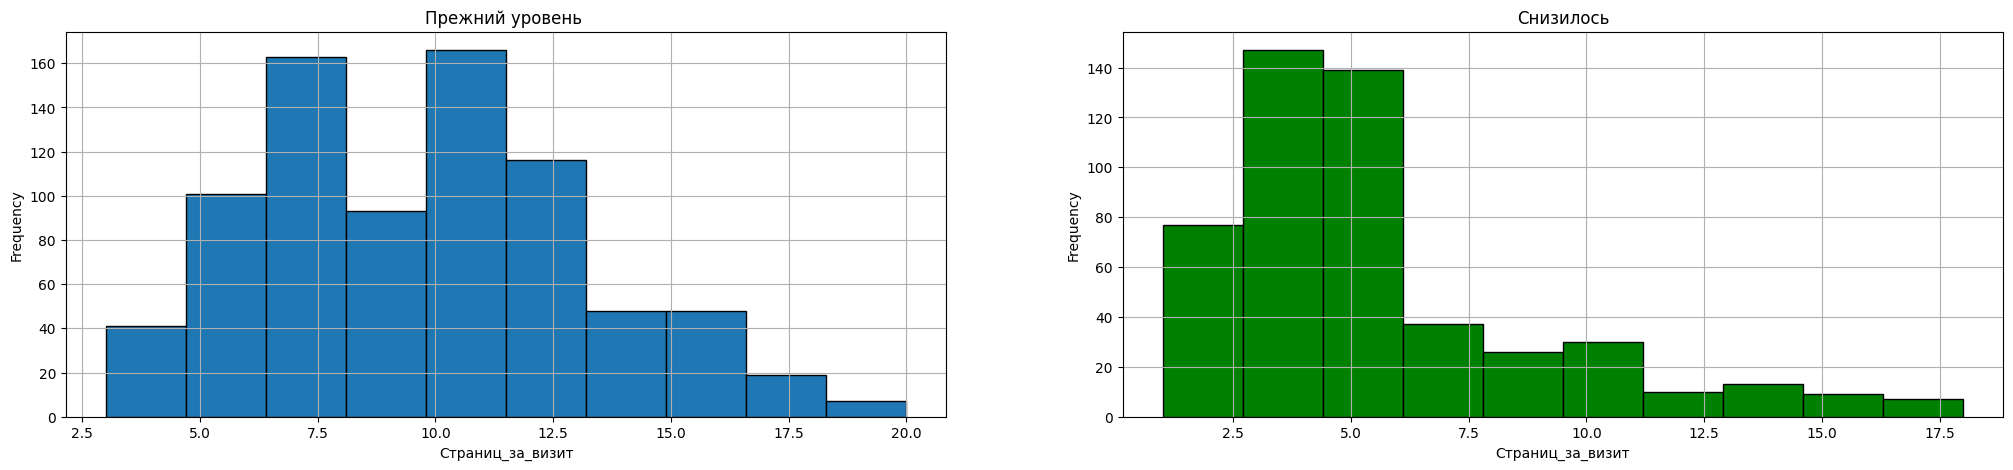

In [47]:
hist_plot('Страниц_за_визит')  

Все очень наглядно "Снизилось" они же "ждуны" или назовем их "целевики"(людт не подвержанные спонтанным покупкам) посещают несколо страниц из как мы помним 2 максимум трех категорий, а клиенты категории "Прежний уровень" больше категорий больше страниц посещений.

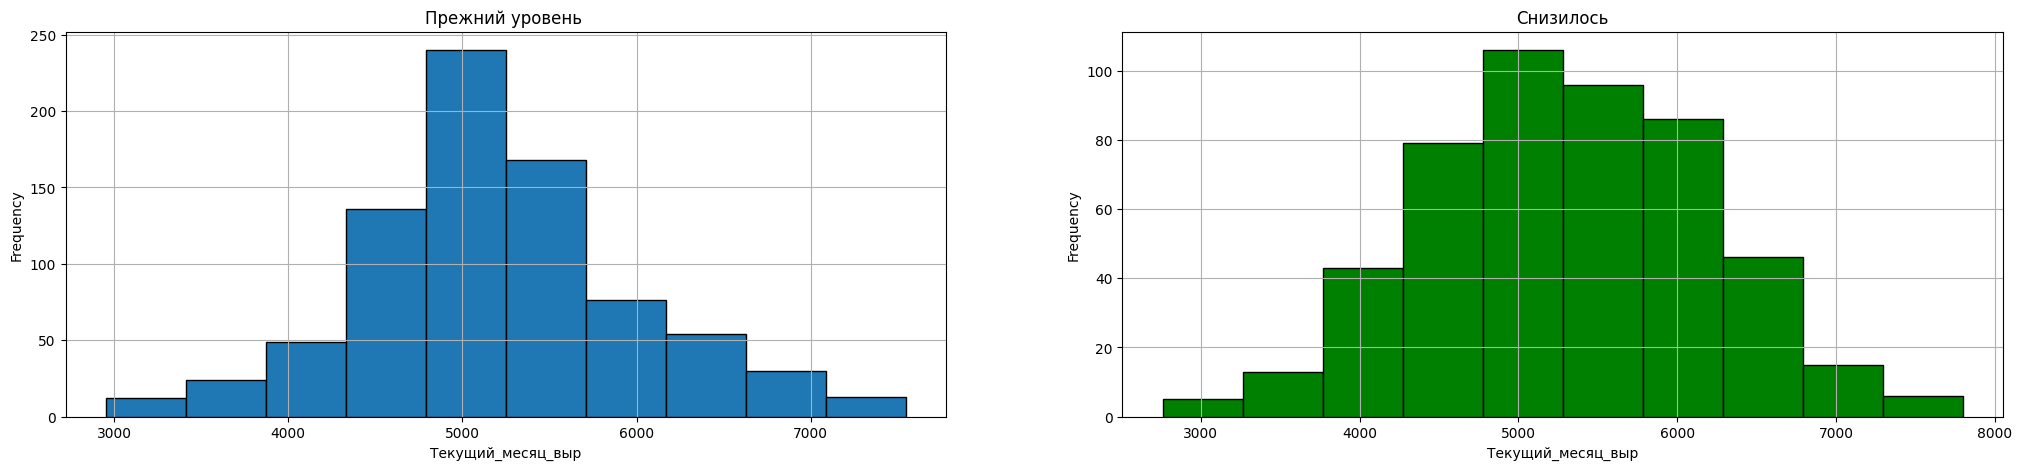

In [48]:
hist_plot('Tекущий_месяц_выр')  

Выручка у "Снизилось" более полог, опять же сорее всего это вызвано высокой покупательской активностью акционных товаров, плюс она седят в среденем в двух котегориях что тоже дает одинаковые уровень цен. У "Прежний уровень" разные категории разные цены разные клиенты.

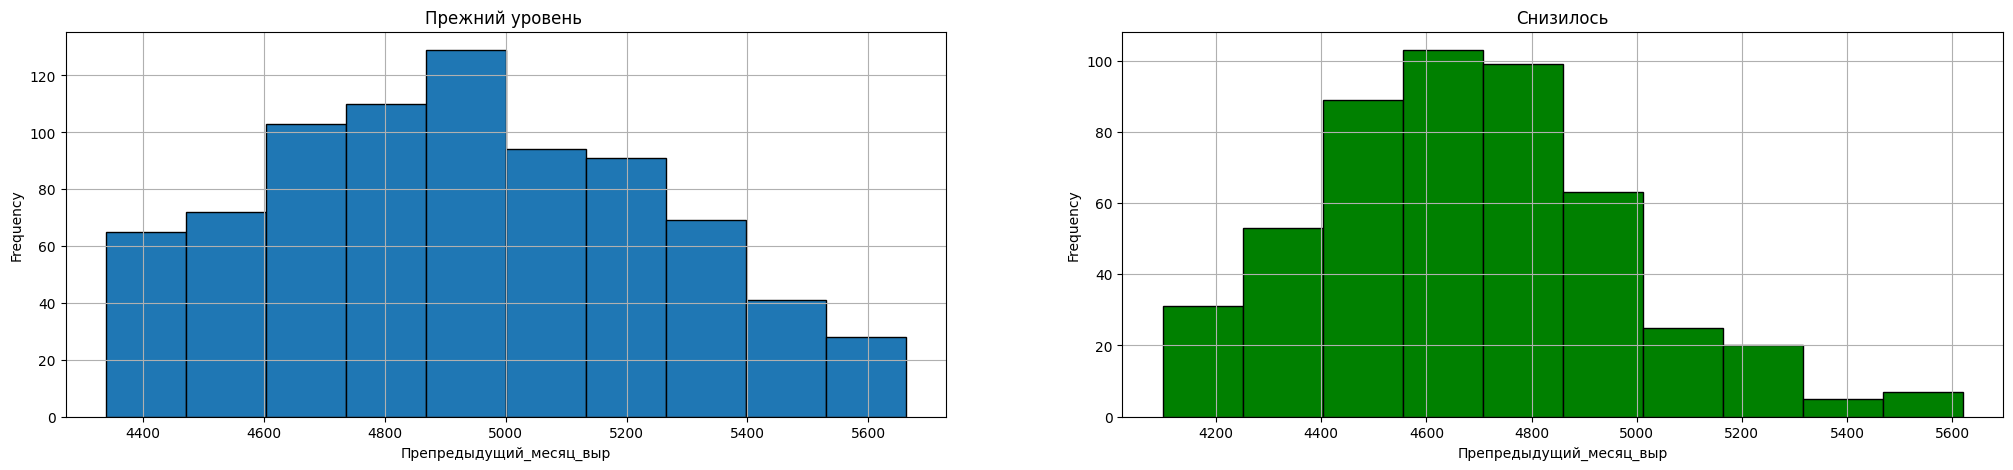

In [49]:
hist_plot('Препредыдущий_месяц_выр')  

Смотри предыдущий вывод

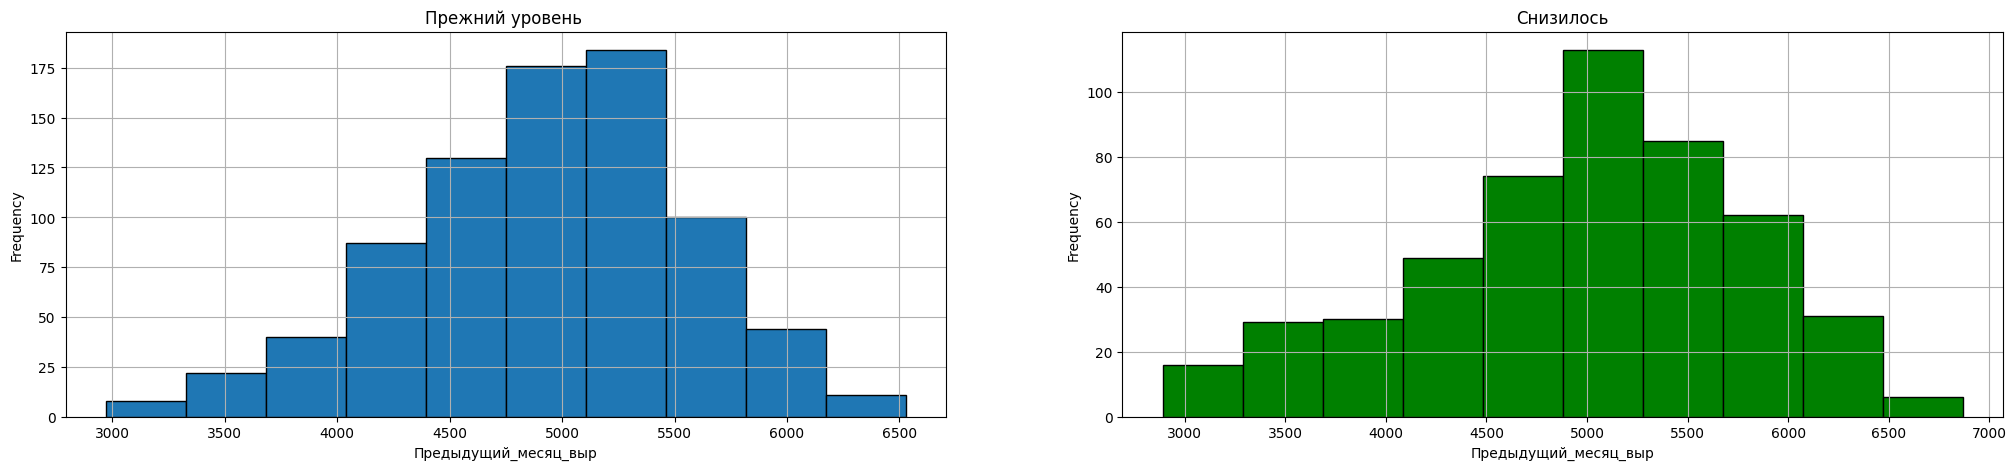

In [50]:
hist_plot('Предыдущий_месяц_выр')  

Смотри предыдущий вывод

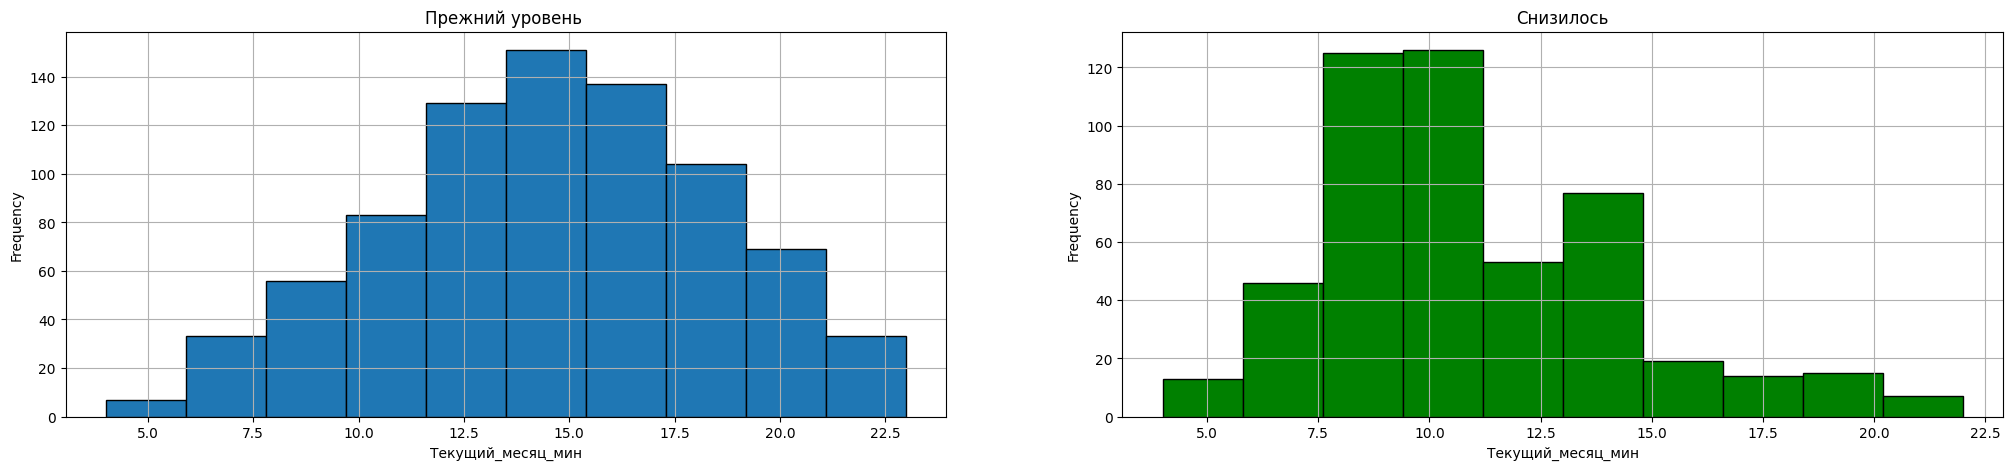

In [51]:
hist_plot('Tекущий_месяц_мин')  

Еще оно подтверждение моего предположения, "Снизилось" меньше категорий меньше страниц меньше времени - "целевики", ищут только целевой товар. В то время "прежний уровень" продолжает посещать разные категории. 

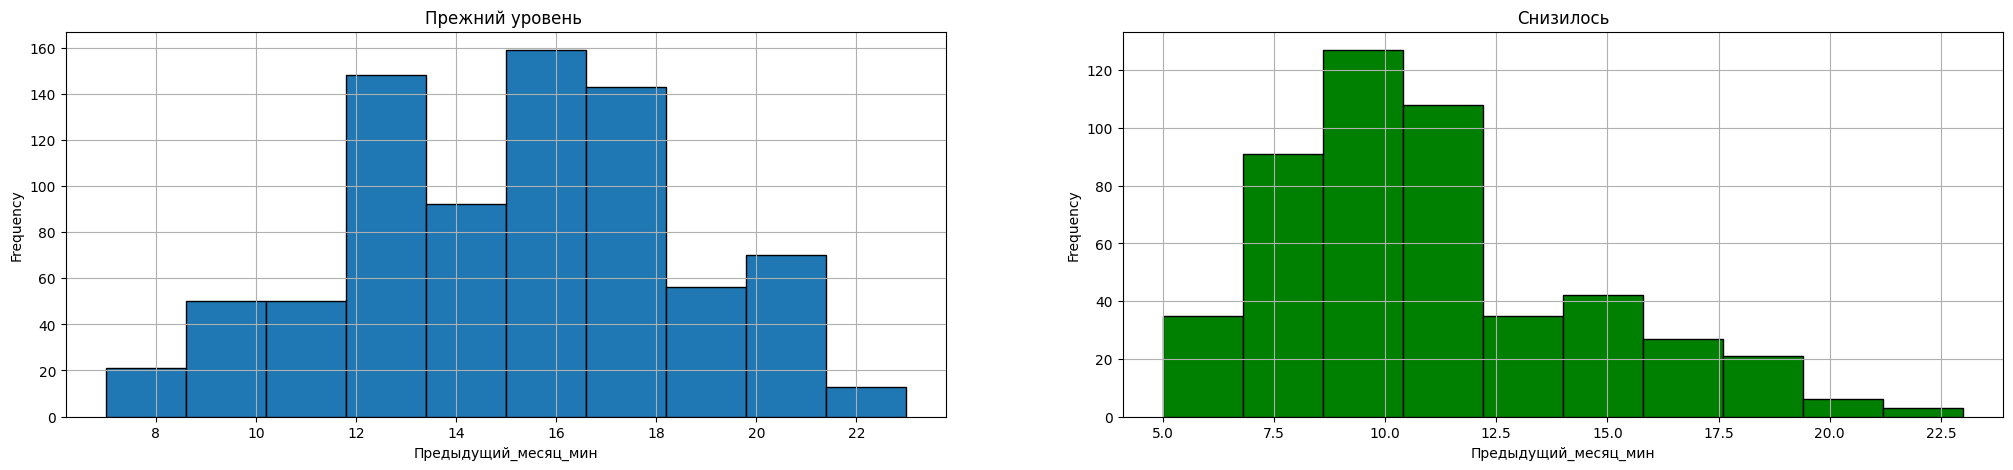

In [52]:
hist_plot('Предыдущий_месяц_мин')

Смотри предыдущий вывод

In [53]:
def bar_plot(colimns):
    _, axes = plt.subplots(1, 2,figsize=(25,5))
    test = df_full[df_full['Покупательская_активность'] == 'Прежний уровень'].groupby(colimns)\
    .agg({'Покупательская_активность':'count'}).sort_values(by='Покупательская_активность', ascending=False)

    test_1 = df_full[df_full['Покупательская_активность'] == 'Снизилась'].groupby(colimns)\
    .agg({'Покупательская_активность':'count'}).sort_values(by='Покупательская_активность', ascending=False)


    test.plot(kind='bar', subplots=True, fontsize=15, figsize=(20,5), ax=axes[0], grid=True, edgecolor='black',  rot=45, legend=False)
    test_1.plot(kind='bar', subplots=True, fontsize=15, figsize=(20,5), ax=axes[1], grid=True, edgecolor='black', color='green',  rot=45, legend=False)
    pass


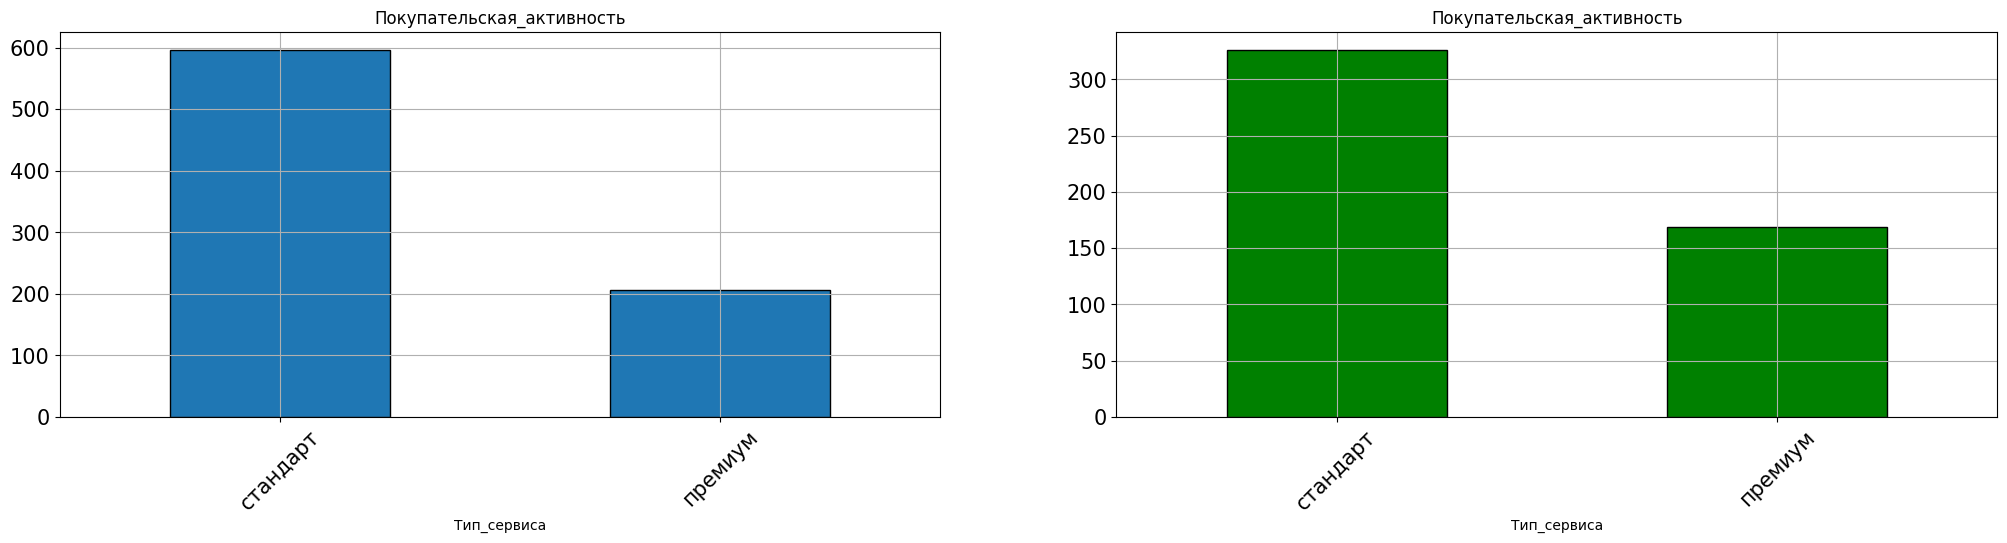

In [54]:
bar_plot('Тип_сервиса')

В этой категории все довольно стандартно :-)

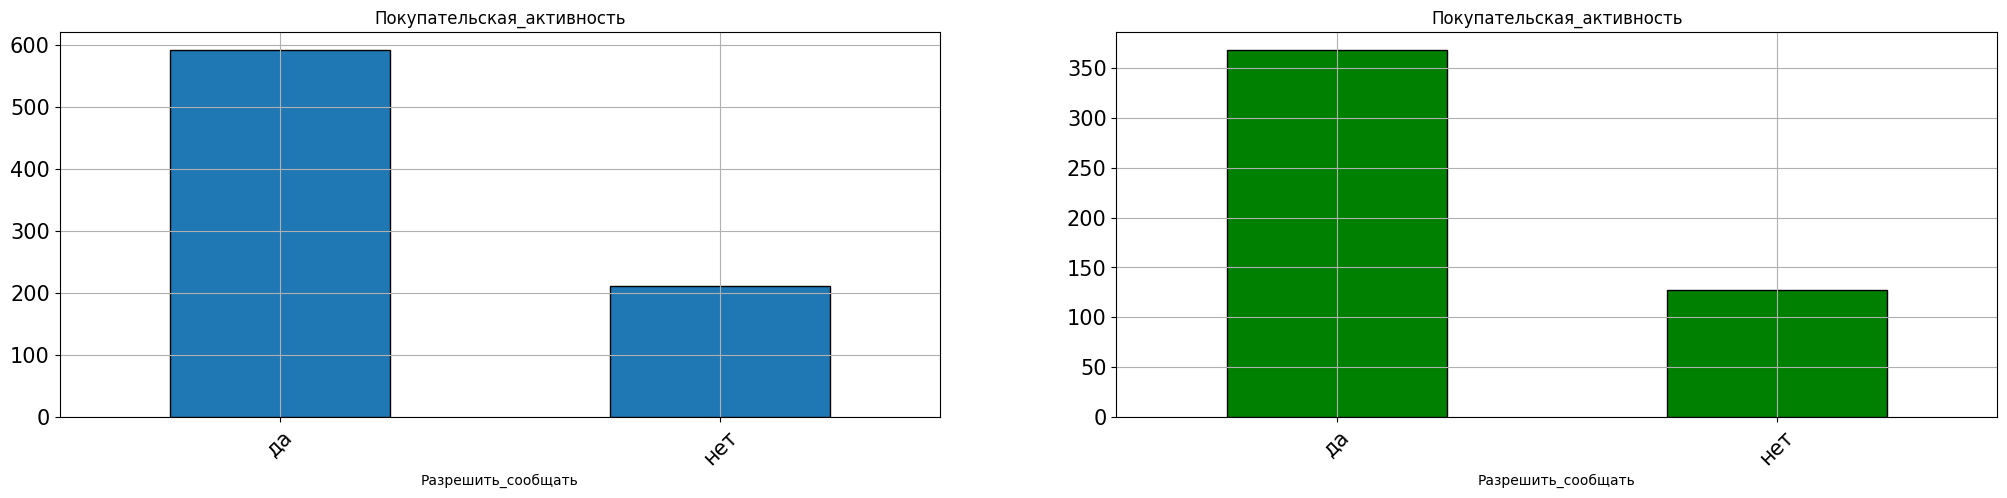

In [55]:
bar_plot('Разрешить_сообщать')

Люди давольно лояльны 

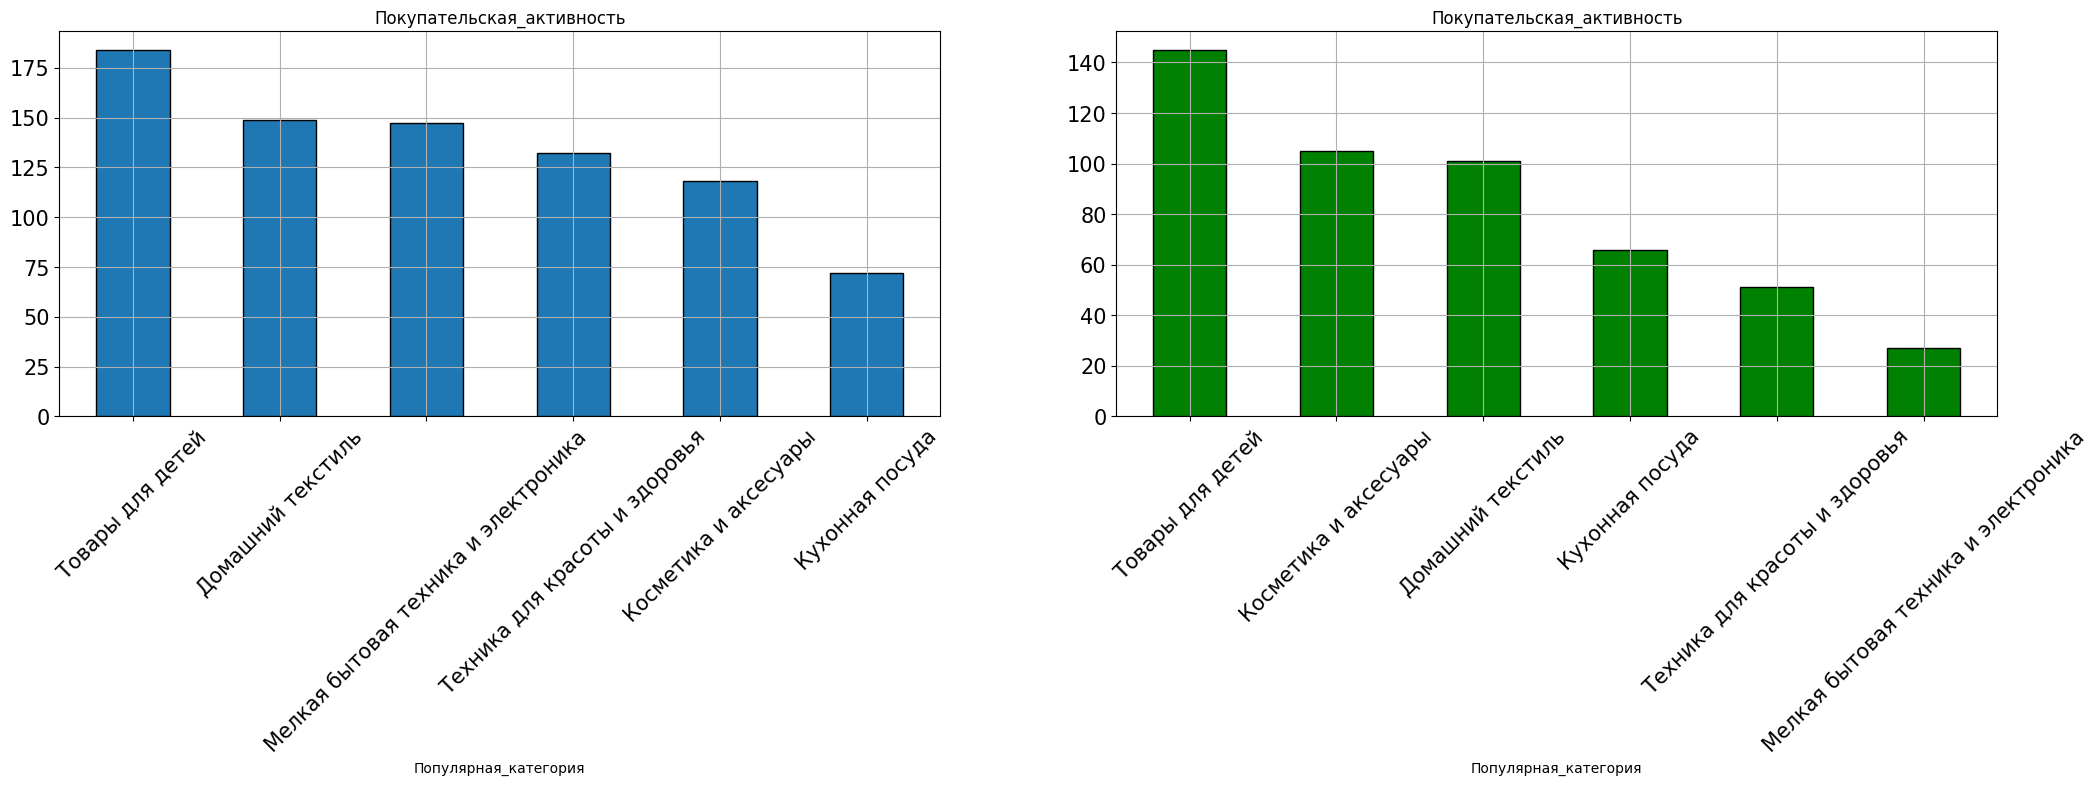

In [56]:
bar_plot('Популярная_категория')

Неизменно самая популяьная категория "товары для деней", "домашний текстиль" и "мелкая бытовая техника и электроника"-категория с приобладающей долей мужской части клиентов, зеленый восновном женщины. 

# Шаг 5. Корреляционный анализ #

In [57]:
columns =df_full.select_dtypes(exclude='object').columns.to_list()

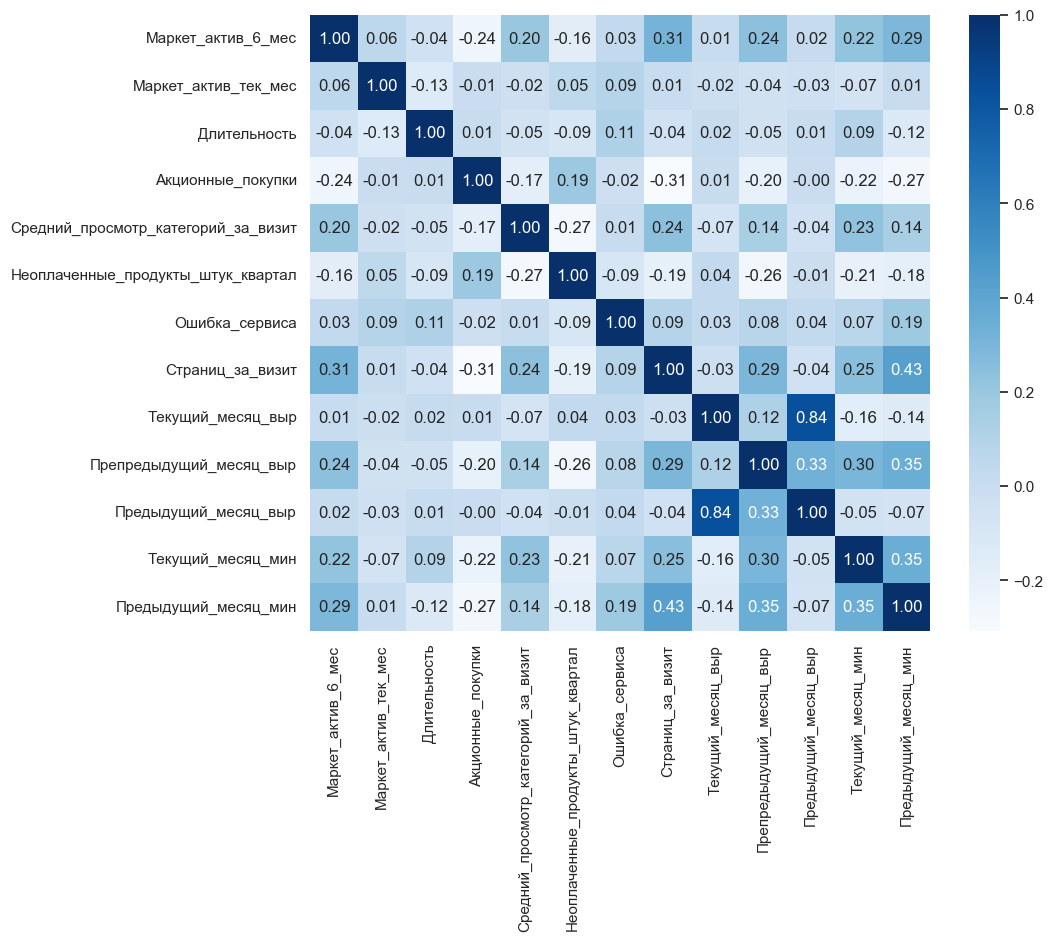

In [58]:
sns.set (rc = {'figure.figsize':(10, 8)})
sns.heatmap(df_full[columns].corr(), cmap="Blues", annot=True,fmt='.2f')
pass

__Вывод:__   
Из данных выше, мы можем сказать, что сильнее всего коррелируются два параметра "Предыдущий_месяц_выр" и "Tекущий_месяц_выр" говорить о мультиколлинеарности покак рано так как значение не достигло 90%.

Многие из этих параметров оказывают довольно слабое влияние, но если попробовать их объединить в одну группу, то, наверняка, можно будет построить хорошую предсказательную модел.  

___Исследуем Мультиколлинеарность___

Мультиколлинеарность - это явление, при котором два или более признака взаимно связаны друг с другом, что может вызвать проблемы при построении модели. Два основных типа проблем, связанных с мультиколлинеарностью:

Затруднение интерпретации коэффициентов: Когда мультиколлинеарность присутствует, сложно определить точный вклад каждого признака в предсказание, так как их эффекты смешиваются между собой;

Неустойчивость коэффициентов: Малейшие изменения в данных могут привести к значительным изменениям коэффициентов модели, что делает результаты менее надежными и устойчивыми;

Мультиколлинеарность может быть особенно проблематичной для наших моделей, линейная регрессия, логистическая регрессия так как они используют линейную комбинацию признаков.

In [59]:
X = df_full[columns] # Выделяем "независимые" переменные (признаки)

X_with_const = sm.add_constant(X) # Добавляем константу для использования модуля statsmodels

# Рассчитываем VIF для каждого признака
vif = pd.DataFrame()
vif['Feature'] = X_with_const.columns
vif['vif'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif.round(2) # Выводим результаты

,Feature,vif
0,const,352.79
1,Маркет_актив_6_мес,1.22
2,Маркет_актив_тек_мес,1.04
3,Длительность,1.10
4,Акционные_покупки,1.19
5,Средний_просмотр_категорий_за_визит,1.18
6,Неоплаченные_продукты_штук_квартал,1.20
7,Ошибка_сервиса,1.08
8,Страниц_за_визит,1.42
9,Tекущий_месяц_выр,3.86


___VIF (Variance Inflation Factor)___:  
    
VIF измеряет насколько дисперсия коэффициента увеличивается, когда предикторы коррелированы. Если VIF = 1, переменные не коррелированы. Если VIF > 5-10, то существует проблема мультиколлинеарности.
На основе полученных значений VIF можно сделать следующие выводы:  
    
const (константа): Значение VIF для константы 352,79. Это значение можно игнорировать. Важно помнить, что высокое значение VIF для константы не связано с мультиколлинеарностью между признаками;

Остальные признаки: Все признаки имеют значения VIF в диапазоне от 1 до 4,23. Это подтверждает вывод о том, что между признаками нет сильной мультиколлинеарности. Самое высокое значение VIF (__4,23__) у признаков "Предыдущий_месяц_выр" и чуть меньше "Tекущий_месяц_выр", но даже эти значения находятся в приемлемом диапазоне.

__Вывод__: Нет признаков мультиколлинеарности между переменными.

# Шаг 6. Использование пайплайнов #

In [61]:
df_full.isna().sum()

Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Tекущий_месяц_выр                      0
Препредыдущий_месяц_выр                0
Предыдущий_месяц_выр                   0
Tекущий_месяц_мин                      0
Предыдущий_месяц_мин                   0
dtype: int64

In [62]:
df_full.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Tекущий_месяц_выр,Препредыдущий_месяц_выр,Предыдущий_месяц_выр,Tекущий_месяц_мин,Предыдущий_месяц_мин
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,4472.0,5216.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,4826.0,5457.5,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,4793.0,6158.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,4594.0,5807.5,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,5124.0,4738.5,10,10


In [63]:
df_full['Покупательская_активность'] = df_full['Покупательская_активность'].replace(['Прежний уровень', 'Снизилась'],[0, 1]) # меняем на числовые значения

## __Пайплайн__

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop( ['Покупательская_активность'],  axis=1),  df_full['Покупательская_активность'],  test_size = TEST_SIZE,  random_state = RANDOM_STATE,
    stratify = df_full['Покупательская_активность']
)

#X_train.shape, X_test.shape

ohe_columns = ['Разрешить_сообщать', 'Популярная_категория','Тип_сервиса']
#ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал',
                'Ошибка_сервиса', 'Страниц_за_визит', 'Tекущий_месяц_выр', 'Препредыдущий_месяц_выр', 'Предыдущий_месяц_выр', 'Tекущий_месяц_мин', 'Предыдущий_месяц_мин']

#Добавляем OHE-кодирование в пайплайн
ohe_pipe = Pipeline([('simpleImputer_ohe',  SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
                    ])


#Добавляем Ordinal-кодирование в пайплайн
#ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
#                     ('ord', OrdinalEncoder(categories=['стандарт', 'премиум'], handle_unknown='use_encoded_value', unknown_value=np.nan)),
#                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
#                    ])

#Объединяем 'этапы' подготовки
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
#        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

#Итоговый пайплайн для обучения модели
pipe_final = Pipeline([
    ('preprocessor' , data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 6),
        'models__max_features': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C' : range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc',random_state=RANDOM_STATE, n_jobs=-1)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', (randomized_search.best_estimator_))
print ('Метрика лучшей модели на тренеровочной выборке:', round(randomized_search.best_score_, 2))




Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория',
                                                   'Тип_сервиса']),
                               

### __kNN__

In [65]:
def prepare_data(df):
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop( ['Покупательская_активность'],  axis=1),  df['Покупательская_активность'],  test_size = TEST_SIZE,  random_state = RANDOM_STATE,
    stratify = df['Покупательская_активность'])

    cat_col_names = X_train.select_dtypes(include='object').columns.to_list()
    num_col_names = X_train.select_dtypes(exclude = 'object').columns.to_list() 

    ohe = OneHotEncoder(sparse=False, drop='first')

    X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
    X_test_ohe  = ohe.transform(X_test[cat_col_names])

    encoder_col_names = ohe.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
    X_test_ohe  = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

    scaler = StandardScaler()

    X_train[num_col_names] = scaler.fit_transform(X_train[num_col_names])
    X_test[num_col_names]  = scaler.transform(X_test[num_col_names])

    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    X_train = pd.concat((X_train[num_col_names], X_train_ohe), axis=1)
    X_test = pd.concat((X_test[num_col_names], X_test_ohe), axis=1)
    
    return X_train, X_test, y_train, y_test
    

In [66]:
X_train, X_test, y_train, y_test = prepare_data(df_full)
    
metric = ['euclidean','cityblock']
for i in metric:
    model = KNeighborsClassifier(n_neighbors= 300, metric=i)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    print('Accuracy', i ,' =', round(accuracy,2))    
    print(f"F1 = {f1_score(y_test, preds, pos_label=1):.2f}")   

Accuracy euclidean  = 0.85
F1 = 0.76
Accuracy cityblock  = 0.88
F1 = 0.82


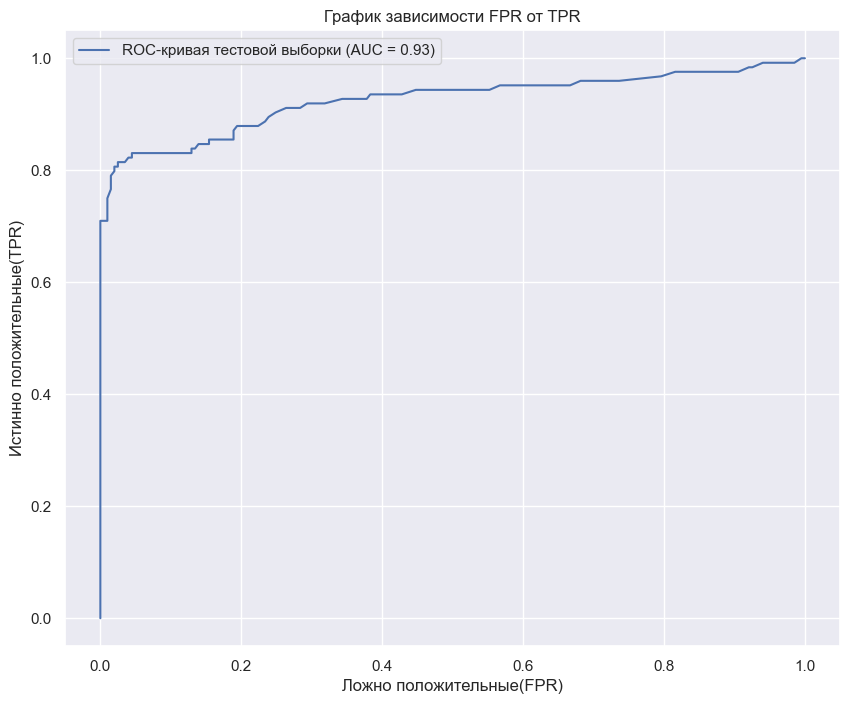

In [67]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

preds = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, preds[:,1], pos_label= 1)
roc_auc_test = roc_auc_score(y_test, preds[:,1])


plt.plot(fpr, tpr, label='ROC-кривая тестовой выборки (AUC = %0.2f)' % roc_auc_test)
plt.title("График зависимости FPR от TPR")
plt.xlabel('Ложно положительные(FPR)')
plt.ylabel('Истинно положительные(TPR)')
plt.legend()
plt.show()

ROC-AUC =  0.93


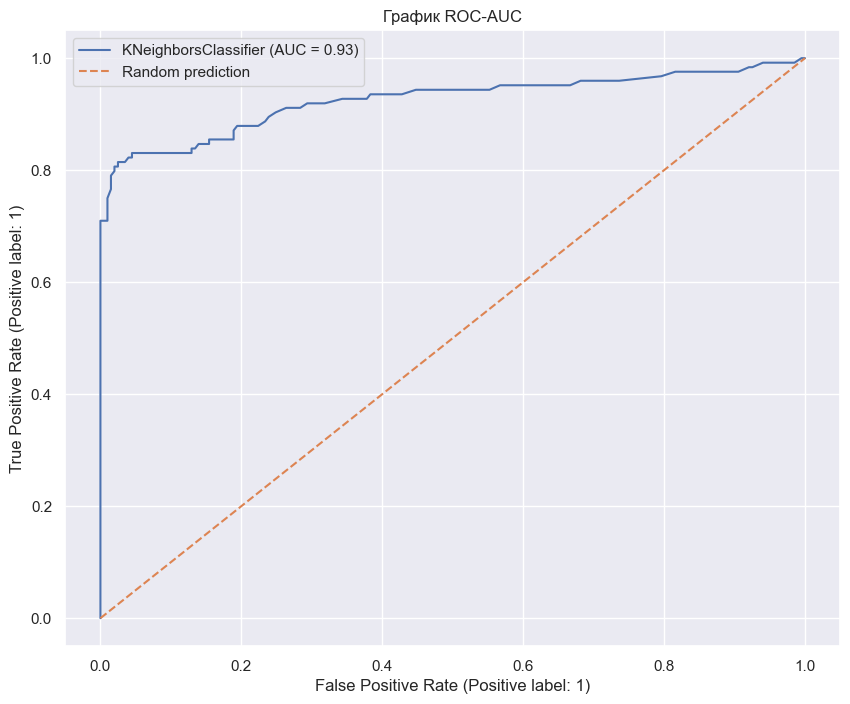

In [68]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

preds = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, preds[:,1]) 
print('ROC-AUC = ', roc_auc.round(2))


RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Random prediction')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

## __Дерево решений__

In [69]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

model = DecisionTreeClassifier(random_state=RANDOM_STATE)

parameters =  {'min_samples_split': range(2, 7),
              'min_samples_leaf': range(2, 12),
              'max_depth': range(1, 6)
              }
gs = GridSearchCV( model, parameters, n_jobs=-1, cv=5, scoring= 'roc_auc')
gs.fit(X_train, y_train)

rs = RandomizedSearchCV(model, parameters, scoring='roc_auc', n_jobs=-1, cv=5,  random_state=RANDOM_STATE) 
rs.fit(X_train, y_train)

oscv_parameters = {
    'min_samples_split': distributions.IntDistribution(2, 7),
    'min_samples_leaf': distributions.IntDistribution(2, 12),
    'max_depth': distributions.IntDistribution(1, 6),
    }

oscv =  OptunaSearchCV(model, oscv_parameters, scoring='roc_auc', cv=5, n_trials=20, random_state=RANDOM_STATE)
oscv.fit(X_train, y_train)

result = pd.DataFrame([
    [gs.best_score_, gs.best_params_],
    [rs.best_score_, rs.best_params_],
    [oscv.best_score_, oscv.best_params_]])

result.index = ['GridSearchCV', 'RandomizedSearchCV', 'OptunaSearchCV']
result.columns = ['best_score_', 'best_params_']
result

[I 2023-12-21 05:12:43,017] A new study created in memory with name: no-name-8d15f618-7b0a-4c7c-9f1a-3dc3a8486259
[I 2023-12-21 05:12:43,042] Trial 0 finished with value: 0.7447408234680962 and parameters: {'min_samples_split': 4, 'min_samples_leaf': 11, 'max_depth': 1}. Best is trial 0 with value: 0.7447408234680962.
[I 2023-12-21 05:12:43,071] Trial 1 finished with value: 0.8046531395031395 and parameters: {'min_samples_split': 3, 'min_samples_leaf': 7, 'max_depth': 2}. Best is trial 1 with value: 0.8046531395031395.
[I 2023-12-21 05:12:43,099] Trial 2 finished with value: 0.8046531395031395 and parameters: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 2}. Best is trial 1 with value: 0.8046531395031395.
[I 2023-12-21 05:12:43,133] Trial 3 finished with value: 0.8741002109547564 and parameters: {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 6}. Best is trial 3 with value: 0.8741002109547564.
[I 2023-12-21 05:12:43,163] Trial 4 finished with value: 0.833335

,best_score_,best_params_
GridSearchCV,0.872319,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_..."
RandomizedSearchCV,0.859083,"{'min_samples_split': 4, 'min_samples_leaf': 1..."
OptunaSearchCV,0.878882,"{'min_samples_split': 2, 'min_samples_leaf': 8..."


## __LogisticRegression__

In [70]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')  
model = model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

# оцениваем accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Значение Accuracy: = {round(acc, 2)}')

Значение Accuracy: = 0.91


## __SVC__

In [71]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

kernels = ['rbf','sigmoid', 'linear', 'poly']
for kernel in kernels:
    svc = SVC(kernel = kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(kernel,' ' ,round(accuracy, 2))

rbf   0.91
sigmoid   0.86
linear   0.91
poly   0.88


__7. Анализ важности признаков__

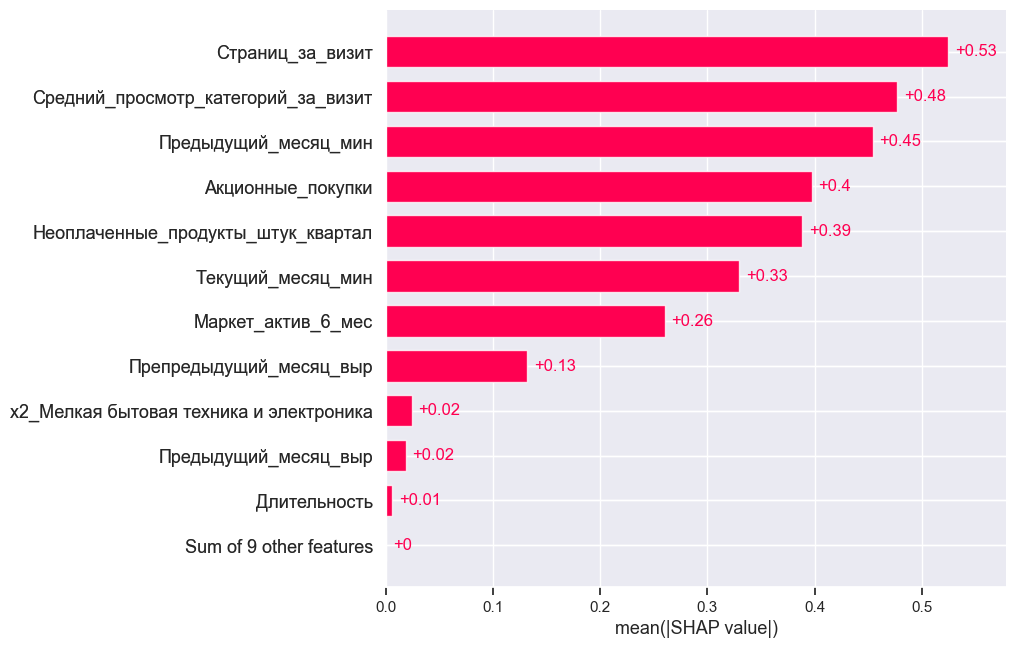

Лидируют категрии так или иначи связанные с временем посещения магазина, так же вполне очевино что неоплаченные покупки ждут акции.


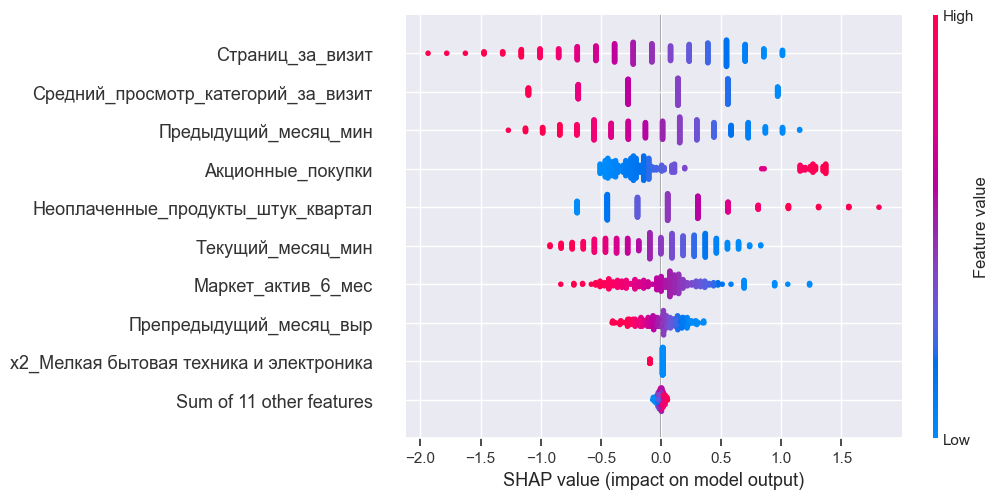

Высокое значение "Страниц за визит" снижает вероятность остаться в категории "Прежний уровень". Не очень понятно как "Страниц за визит" повышает риск перейти в категорию "Снизилось". Судя по всему надо смотреть и на другие признаки, средний просмотр категорий за визит очень даже "не плох", еще более хорош это акцонные покупки. Можно подвести предворительные выводы: Неоптимизирован поиск трубуемого продукта что приводит к долгому листанию страниц и поиску необходимого тавара, тоесть продукты на сестиматезированны в нетри категрии, также недо внимательнее отнестись к распределеию товара в категрии (более логично). А вот с Акционными продуктами все очень не плохо люди их видят и покупают.


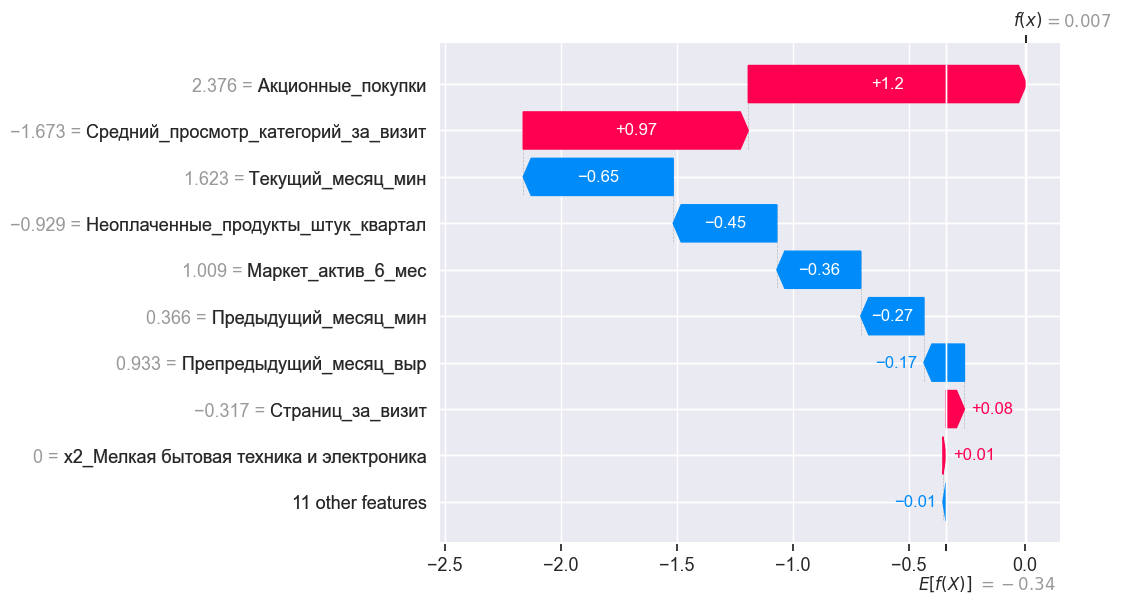

Ну чтож с большой натяжкой можно отнести к 1 классу. неоптимизированные поиск приводит к проблемам, радуют Акционные покупки и просмотр категорий за визит, но все остальное вывывает только раздрожение у клиетнов это потраченное время на поиск товара это не сильно универсальная и эжффективная акционная программа и довольно безтолковая меркетигновое взаимодействие которое больше мешает чем помогает как вариант маркетинг и акции могут быть связаны (хоты в жизни зачаcтую нет).


In [73]:
X_train, X_test, y_train, y_test = prepare_data(df_full)

model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', C=0.1)
model = model.fit(X_train, y_train) 

explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values, max_display=12) 
print('Лидируют категрии так или иначи связанные с временем посещения магазина, так же вполне очевино что неоплаченные покупки ждут акции.')
shap.plots.beeswarm(shap_values) 
print('Высокое значение "Страниц за визит" снижает вероятность остаться в категории "Прежний уровень". Не очень понятно как "Страниц за визит" повышает риск перейти в категорию "Снизилось". Судя по всему надо смотреть и на другие признаки, средний просмотр категорий за визит очень даже "не плох", еще более хорош это акцонные покупки. Можно подвести предворительные выводы: Неоптимизирован поиск трубуемого продукта что приводит к долгому листанию страниц и поиску необходимого тавара, тоесть продукты на сестиматезированны в нетри категрии, также недо внимательнее отнестись к распределеию товара в категрии (более логично). А вот с Акционными продуктами все очень не плохо люди их видят и покупают.')

shap.plots.waterfall(shap_values[0]) 
print('Ну чтож с большой натяжкой можно отнести к 1 классу. неоптимизированные поиск приводит к проблемам, радуют Акционные покупки и просмотр категорий за визит, но все остальное вывывает только раздрожение у клиетнов это потраченное время на поиск товара это не сильно универсальная и эжффективная акционная программа и довольно безтолковая меркетигновое взаимодействие которое больше мешает чем помогает как вариант маркетинг и акции могут быть связаны (хоты в жизни зачаcтую нет).')


__Шаг 8. Сегментация покупателей__

In [75]:
test = df_full.copy().reset_index() 

test['Сум_выручка_за_3_месяца'] = test[['Tекущий_месяц_выр', 'Предыдущий_месяц_выр', 'Препредыдущий_месяц_выр']].sum(axis=1)# добавляем колонку суммарный доход за три месяца
test['Сум_выручка_за_3_месяца'] = np.ceil(test['Сум_выручка_за_3_месяца'])# округляем значения
test_1= test.copy()

In [170]:
def lern(column):
    
    X_train, X_test, y_train, y_test = train_test_split(
    test.drop([column],  axis=1),  test[column],  test_size = TEST_SIZE,  random_state = RANDOM_STATE)


    X_test = test.drop([column],  axis=1).copy()

    cat_col_names = X_train.select_dtypes(include='object').columns.to_list()
    num_col_names = X_train.select_dtypes(exclude = 'object').columns.to_list() 
    

    ohe = OneHotEncoder(sparse=False, drop='first')

    X_train_ohe = ohe.fit_transform(X_train[cat_col_names])
    X_test_ohe  = ohe.transform(X_test[cat_col_names])

    encoder_col_names = ohe.get_feature_names()

    X_train_ohe = pd.DataFrame(X_train_ohe, columns = encoder_col_names)
    X_test_ohe  = pd.DataFrame(X_test_ohe, columns = encoder_col_names)

    scaler = StandardScaler()

    X_train[num_col_names] = scaler.fit_transform(X_train[num_col_names])
    X_test[num_col_names]  = scaler.transform(X_test[num_col_names])
    
    X_train = X_train.reset_index(drop=True)
    X_test  = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    X_train = pd.concat((X_train[num_col_names], X_train_ohe), axis=1)
    X_test = pd.concat((X_test[num_col_names], X_test_ohe), axis=1)

    #lab = preprocessing.LabelEncoder() # преобразование непрерывные в категориальные
    #y_train = lab.fit_transform( y_train)
    
    
    model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')  
    model = model.fit(X_train,  y_train) 

    #predictions = model.predict(X_test)



    #for i in range(len(test_1)):
    test_1['Вероятность_снижения_активности']  = model.predict_proba(X_test)[:,1]
    #print(f"Прогноз: {predictions[0]}")

In [198]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    test_1.drop( ['Покупательская_активность'],  axis=1),  test_1['Покупательская_активность'],  test_size = TEST_SIZE,  random_state = RANDOM_STATE,
    stratify = test_1['Покупательская_активность'])
df_predicted = X_test_1.copy()

In [202]:
df_predicted['Вероятность снижения активности'] = model.predict_proba(X_test)[:,1]
test_1 = df_predicted.copy()

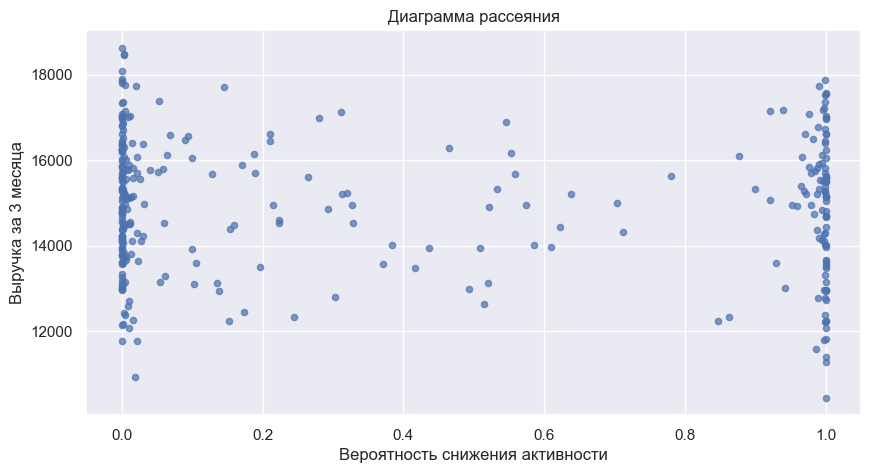

In [204]:
test_1.plot(kind = 'scatter', x = 'Вероятность_снижения_активности', 
                                            y ='Сум_выручка_за_3_месяца' , alpha = 0.7, xlabel = 'Вероятность снижения активности',  
                                            ylabel = 'Выручка за 3 месяца', 
                                            title = 'Диаграмма рассеяния', grid=True, figsize=(10, 5))
pass

Очень хорошо видна граница. Интереное распределеия наименьшее колличество предсказаний в деиапозоне от 0,2 до 0,8.

In [218]:
# Выбираем пользователей у которых прогноз вероянтности сниджения активности более 0,6 и покупки на сумму более 15000 за три месяца
test_2= test_1[(test_1['Сум_выручка_за_3_месяца'] >= 15000) &( test_1['Вероятность_снижения_активности'] >= 0.6)]


Популярная_категория
Косметика и аксесуары                   242810.0
Домашний текстиль                       211839.0
Товары для детей                        207919.0
Кухонная посуда                         163265.0
Мелкая бытовая техника и электроника     78483.0
Техника для красоты и здоровья           45745.0
Name: Сум_выручка_за_3_месяца, dtype: float64


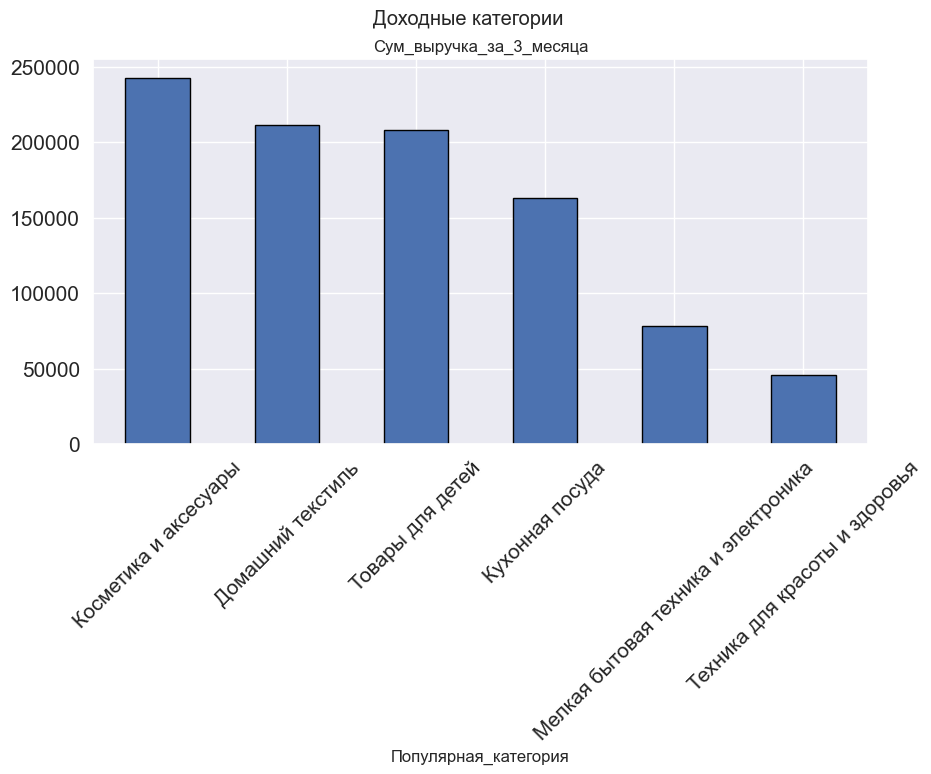

In [207]:
d= test_2.groupby('Популярная_категория')['Сум_выручка_за_3_месяца'].sum().sort_values(ascending=False)
d.plot(kind='bar', subplots=True, fontsize=15, figsize=(10,5), grid=True, edgecolor='black',  rot=45, legend=False, title = 'Доходные категории')
print(d)
pass

Популярная_категория
Косметика и аксесуары                   15
Домашний текстиль                       13
Товары для детей                        13
Кухонная посуда                         10
Мелкая бытовая техника и электроника     5
Техника для красоты и здоровья           3
Name: Сум_выручка_за_3_месяца, dtype: int64


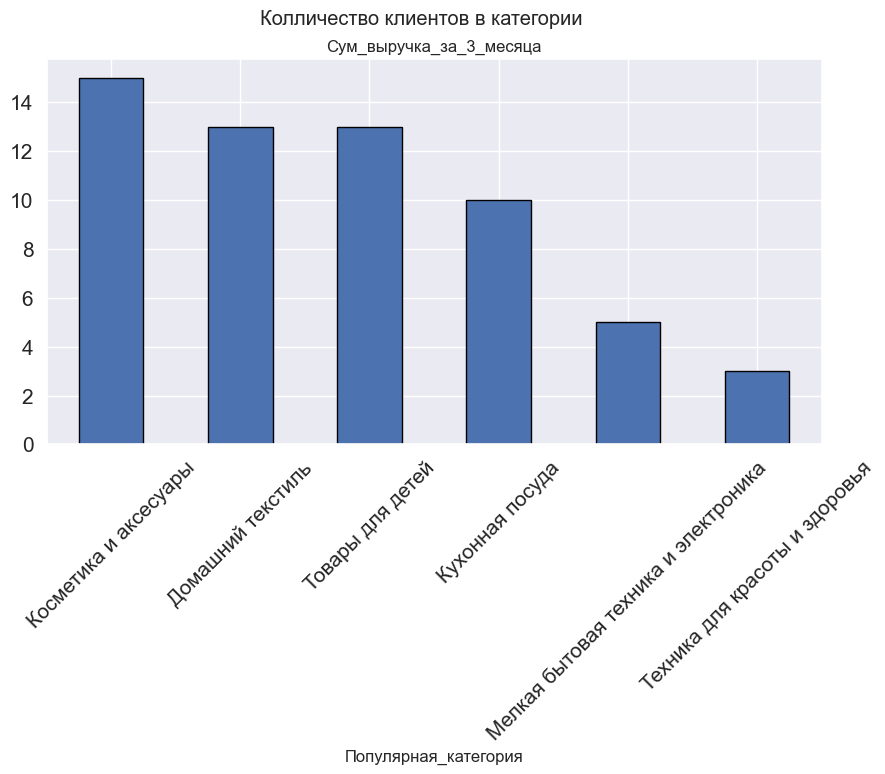

In [208]:
d= test_2.groupby('Популярная_категория')['Сум_выручка_за_3_месяца'].count().sort_values(ascending=False)
d.plot(kind='bar', subplots=True, fontsize=15, figsize=(10,5), grid=True, edgecolor='black',  rot=45, legend=False, title = 'Колличество клиентов в категории')
print(d)
pass

Популярная_категория
Кухонная посуда                         16326.50
Домашний текстиль                       16295.31
Косметика и аксесуары                   16187.33
Товары для детей                        15993.77
Мелкая бытовая техника и электроника    15696.60
Техника для красоты и здоровья          15248.33
Name: Сум_выручка_за_3_месяца, dtype: float64


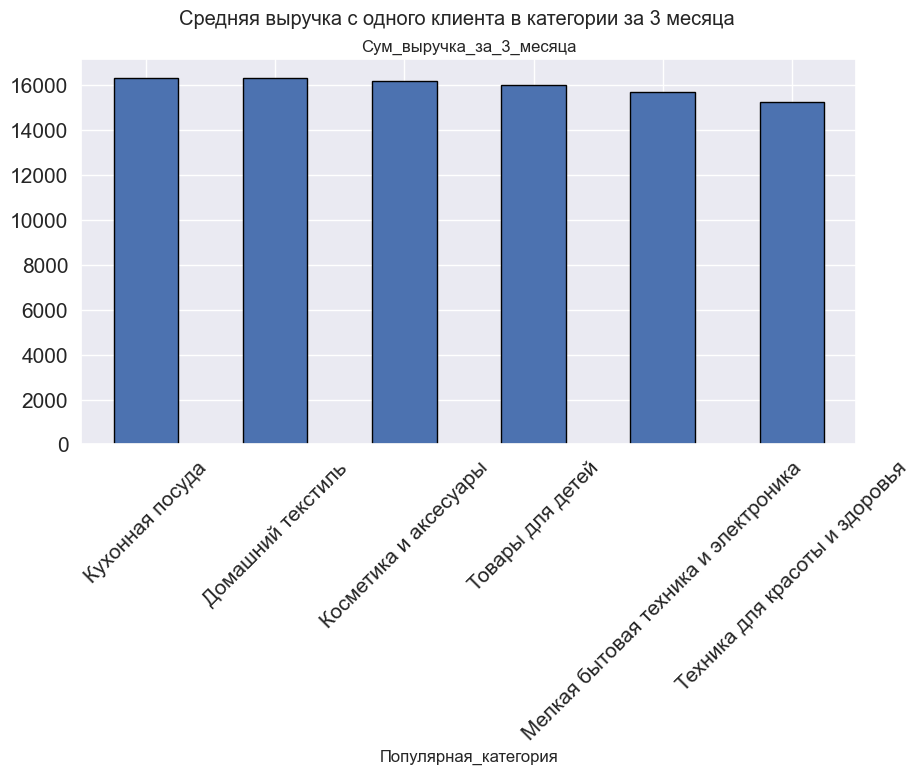

In [244]:
d= test_2.groupby('Популярная_категория')['Сум_выручка_за_3_месяца'].mean().sort_values(ascending=False).round(2)
d.plot(kind='bar', subplots=True, fontsize=15, figsize=(10,5), grid=True, edgecolor='black',  rot=45, legend=False, title = 'Средняя выручка с одного клиента в категории за 3 месяца')
print(d)
pass

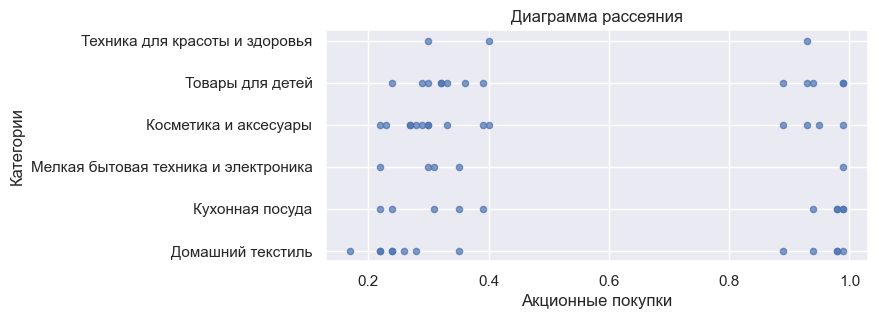

In [242]:
test_2.plot(kind = 'scatter', x = 'Акционные_покупки', 
                                            y ='Популярная_категория' , alpha = 0.7, xlabel = 'Акционные покупки',  
                                            ylabel = 'Категории', 
                                            title = 'Диаграмма рассеяния', grid=True, figsize=(7, 3))
pass

Возьмём пока одну(самую перспективную) группу клиентов, которые покупают товары из категории __«Косметика и аксесуары»__. 

In [211]:
test_for_kids = test_2.query('Популярная_категория == "Косметика и аксесуары"') # создаем отдельную таблицу для исследуемой группы

In [314]:
def scattet_plot(x , y, z = None, f = None, ):
    _, axes = plt.subplots(1, 3,figsize=(15,5))
    test[(test['Покупательская_активность'] == 0) & (test['Популярная_категория'] == "Косметика и аксесуары")].plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[0],
                                            title = 'Лояльные (покупательская активность не менялась)', grid=True,  )
    test[(test['Покупательская_активность'] == 1) & (test['Популярная_категория'] == "Косметика и аксесуары")].plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[1],
                                            title = 'Покуп. активность снизелась', grid=True,color = 'green'  )
    
    test_for_kids.plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[2],
                                            title = 'Предсказания', grid=True, color = 'red')
pass    

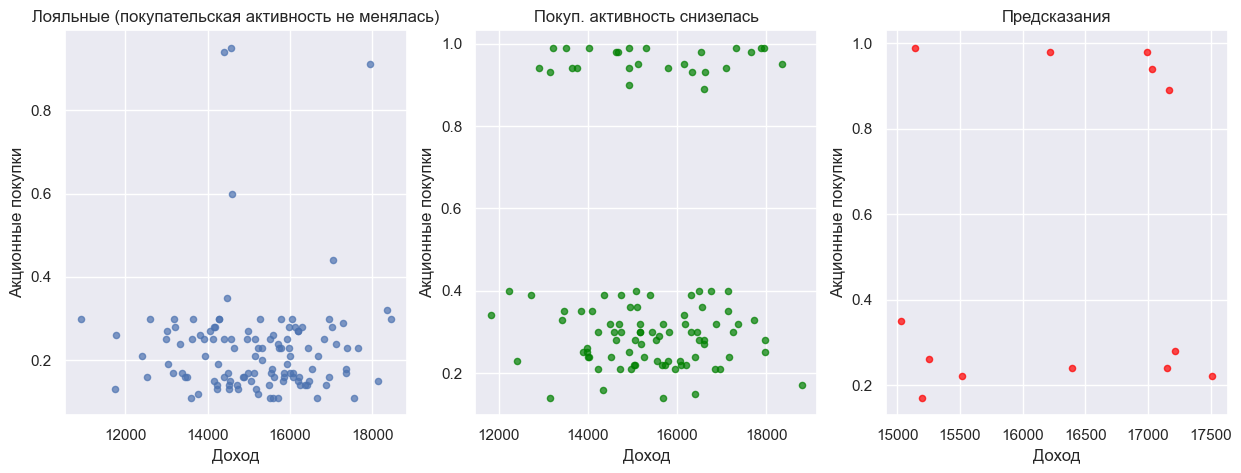

In [315]:
scattet_plot('Сум_выручка_за_3_месяца' , 'Акционные_покупки', 'Акционные покупки', 'Доход')

Акционные покупки головная боль, лояльные покупатели не сильно гоняются за акционным товаром, а покупают по необходимости, в то время как покупатели с сниженной активностью, с большей охотой покупают акционный товар, такая же кортина наблюдается и с предсказанными. Интересно посмотреть категорию как довно был зарегестрирован клиент и акционные покупки. 

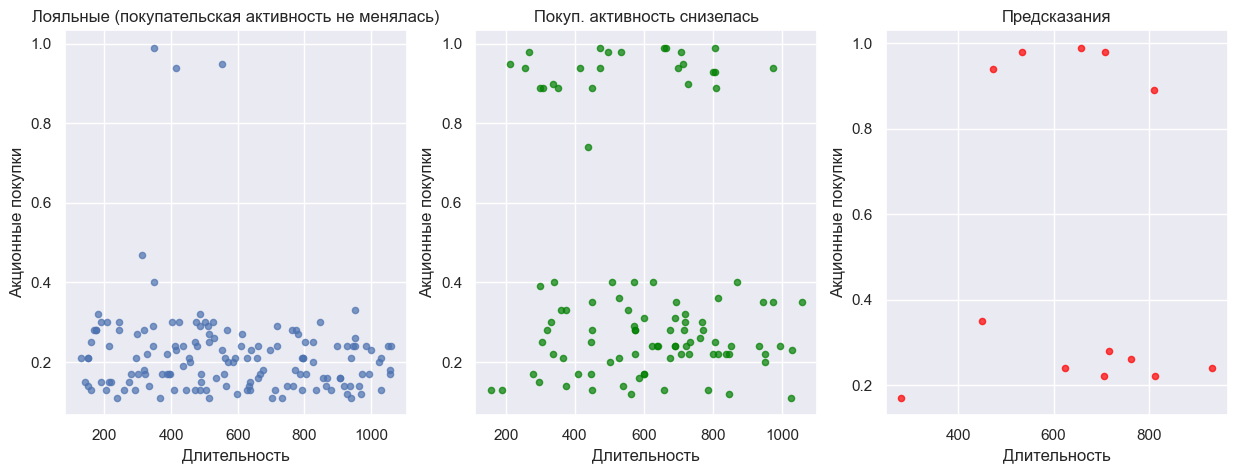

In [326]:
scattet_plot('Длительность' , 'Акционные_покупки', 'Акционные покупки', 'Длительность')

В этой категории нет ничего интересного, оно маленькое уточнение что недавно зарегестрировавшеися клинта это делают ради акционного товара, это нормально.

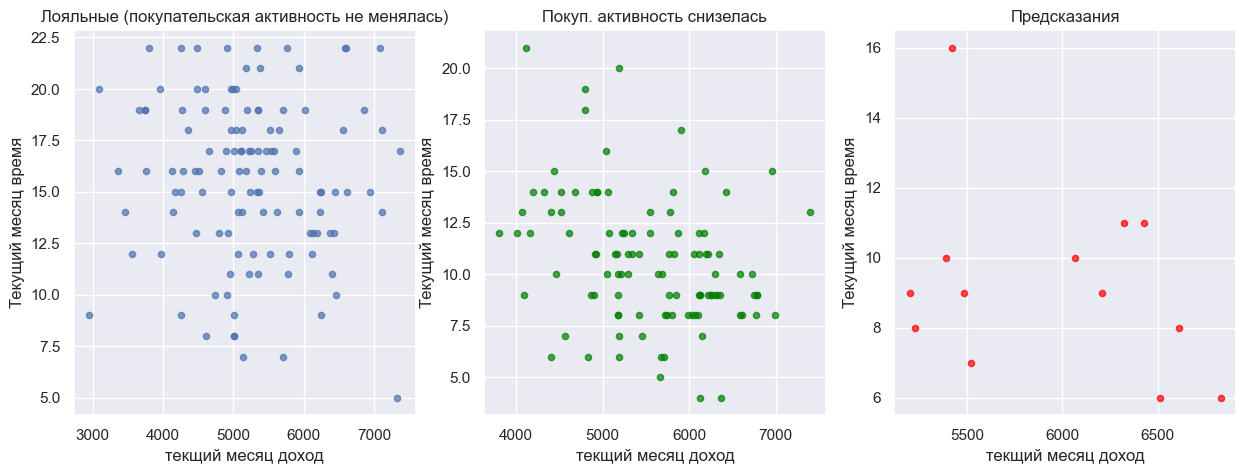

In [316]:
scattet_plot('Tекущий_месяц_выр' , 'Tекущий_месяц_мин', 'Текущий месяц время','текщий месяц доход', )

Лояльные покупатели сидят на сайте от 10 до 20 минут в то время как не лояльные находятся на сайте от 7,5 до 14. Напрашивается вывод что не лояльные люди или приходят на сайт только ради акционных товаров или же они сильно нетерпеливые. Но результат один не лояльные позователи меньше седят на сайте.  
__Вывод:__ Задача маркетологов, надо заставить клиентов проводить на сайте больше времени не вызывая подозрения у санитаров :-)

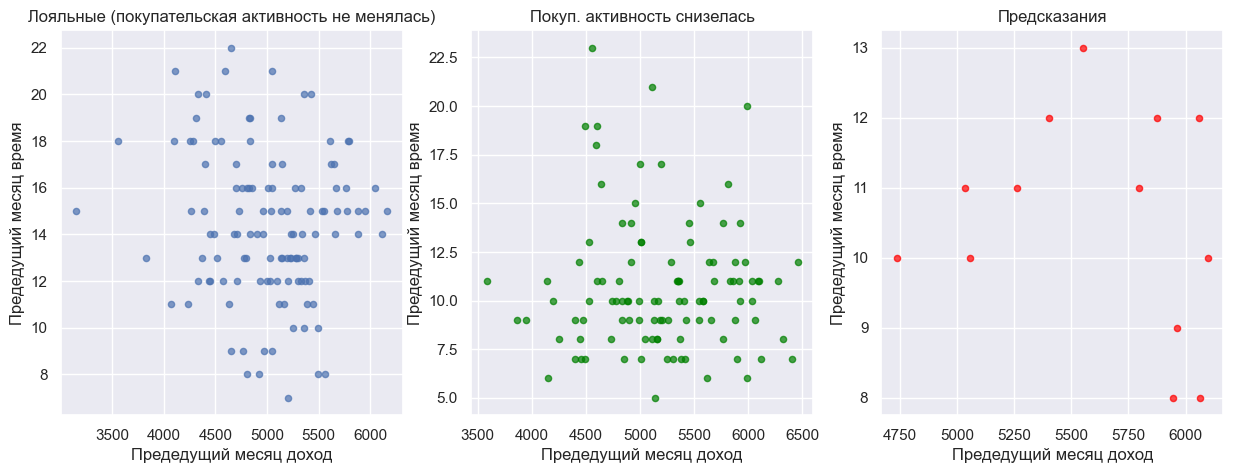

In [317]:
scattet_plot('Предыдущий_месяц_выр' , 'Предыдущий_месяц_мин', 'Предедущий месяц время','Предедущий месяц доход', )

Справедлив предедущий вывод.

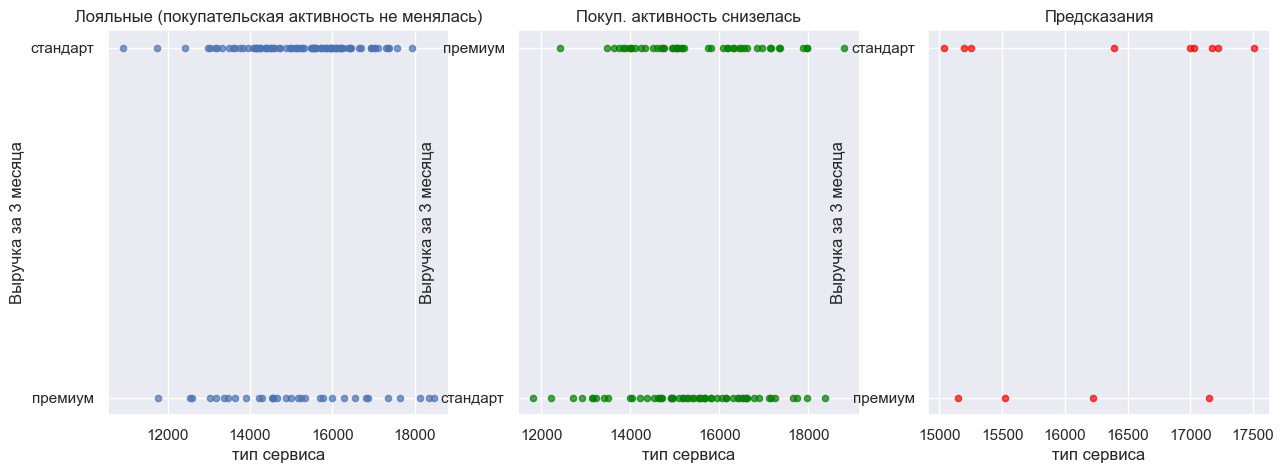

In [318]:
scattet_plot('Сум_выручка_за_3_месяца' , 'Тип_сервиса', 'Выручка за 3 месяца','тип сервиса', )

### Рассмотрим ещё одну категорью с наивысшим приоритетом

Все выводы сделанные в категории косметика и аксесуары справедливы и в этой категории. 

In [319]:
test_for_kids = test_2.query('Популярная_категория == "Домашний текстиль"') # вторая категория

In [320]:
def scattet_plot(x , y, z = None, f = None, ):
    _, axes = plt.subplots(1, 3,figsize=(15,5))
    test[(test['Покупательская_активность'] == 0) & (test['Популярная_категория'] == "Домашний текстиль")].plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[0],
                                            title = 'Лояльные (покупательская активность не менялась)', grid=True,  )
    test[(test['Покупательская_активность'] == 1) & (test['Популярная_категория'] == "Домашний текстиль")].plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[1],
                                            title = 'Покуп. активность снизелась', grid=True,color = 'green'  )
    
    test_for_kids.plot(kind = 'scatter', x = x, 
                                            y =y , alpha = 0.7, ylabel = z,  
                                            xlabel = f, ax = axes[2],
                                            title = 'Предсказания', grid=True, color = 'red')
pass    

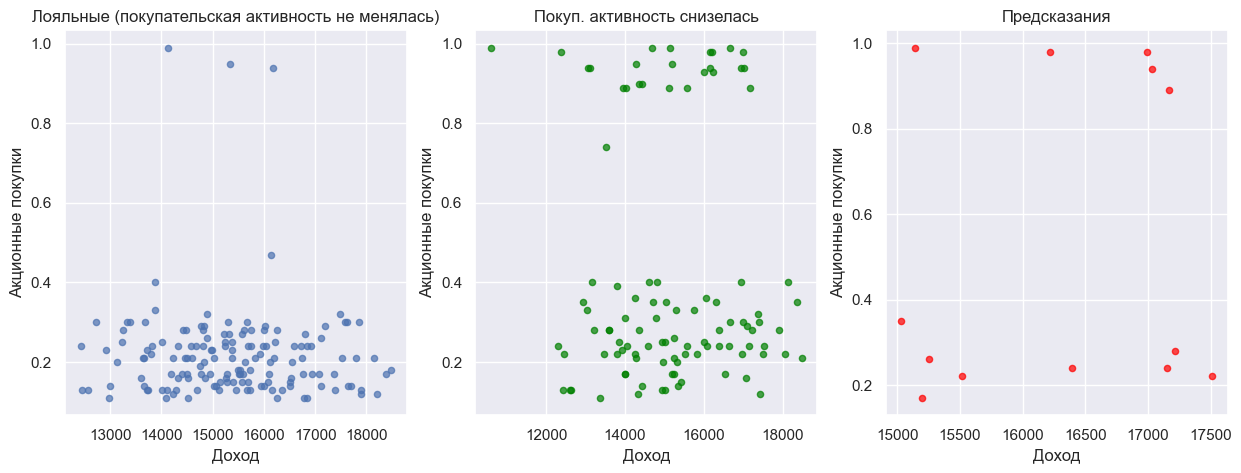

In [321]:
scattet_plot('Сум_выручка_за_3_месяца' , 'Акционные_покупки', 'Акционные покупки', 'Доход',  )

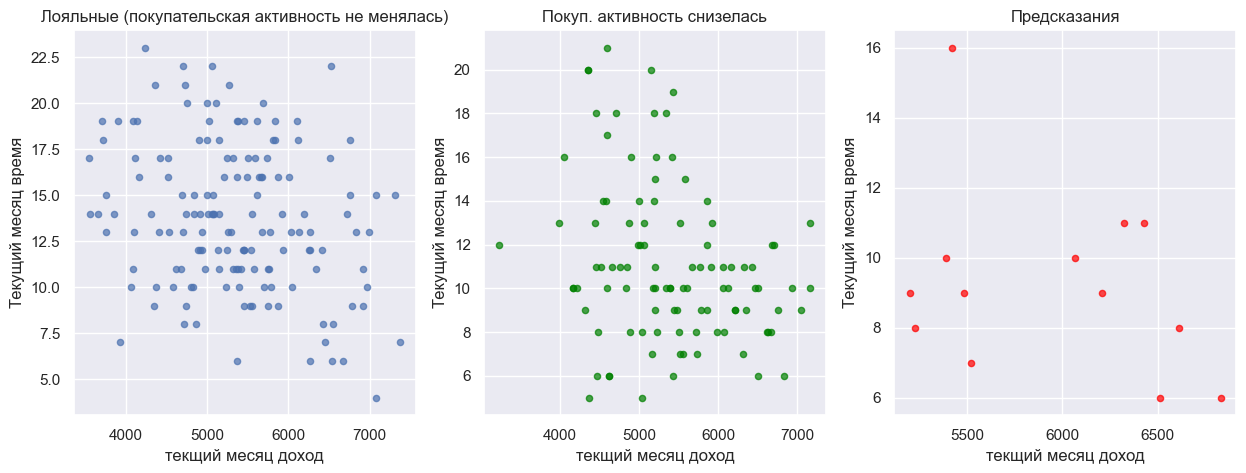

In [322]:
scattet_plot('Tекущий_месяц_выр' , 'Tекущий_месяц_мин', 'Текущий месяц время','текщий месяц доход', )

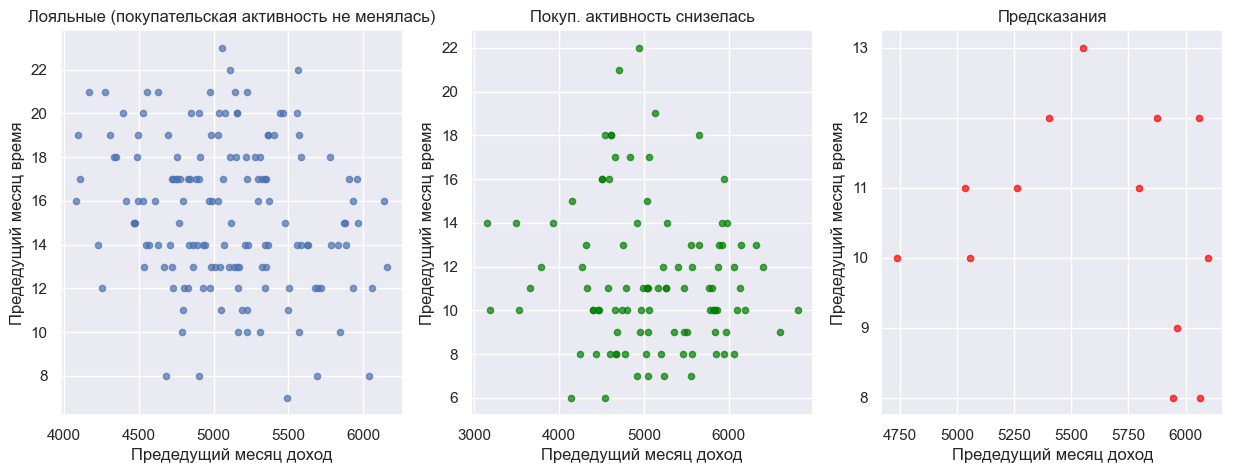

In [323]:
scattet_plot('Предыдущий_месяц_выр' , 'Предыдущий_месяц_мин', 'Предедущий месяц время','Предедущий месяц доход', )

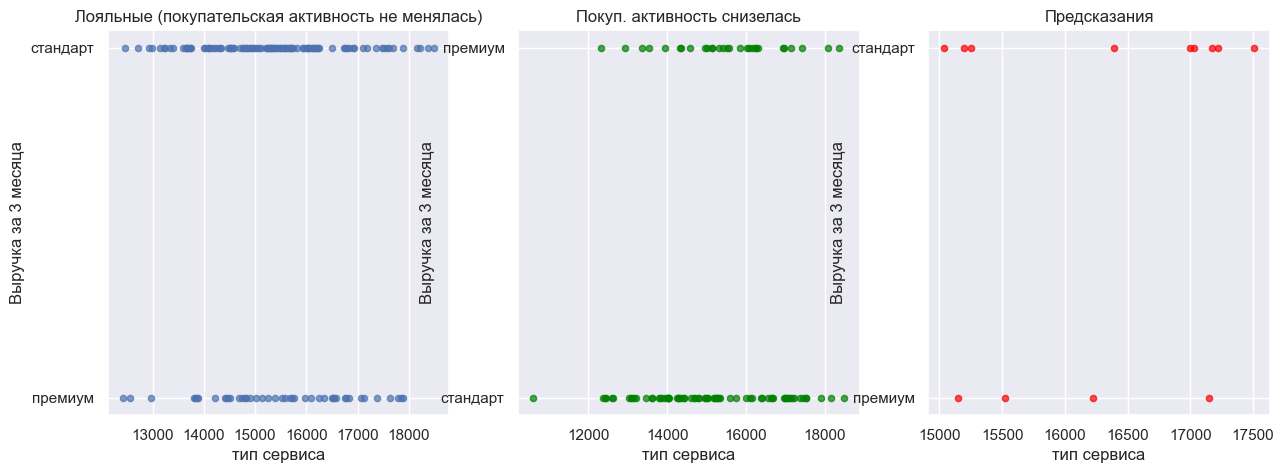

In [324]:
scattet_plot('Сум_выручка_за_3_месяца' , 'Тип_сервиса', 'Выручка за 3 месяца','тип сервиса', )

Разница в типе сервиса практически отсутвует, причем клиенты премиум сервиса и моглибы быть активнее.

__Рекомендации:__
1) Оптемизация сайта со стороны поиска необходимой информации, люди долго искать не хотят.
2) Персаналезировать акционные предлажения, довавлять акционные предложения из смежных групп, в связи с тем что акции поддалкивают клиентав к снижению активности необходмо изменить акционную палитику.
3) Снизить пустую маркетинговую нагрузку на клиентов.
4) Стимиулировать премиум клиентов к большей активности, пересмотреть превелегии примиум клиентов.  
5) Рекомендовал бы добавить акционный товар только для премиум клиентов, так же премиум стату плавующий например небходима покупать на определнённую сумму в определённый промежуток времени. Этим действием мы подстегнём клиентов стать премиум клиентом и оставаться им.

Так же я рекоментовал применить теже дейсвия и к котегориям __"Товары для детей"__ и  __"Домашний текстиль"__



Все три сигмета очень похожи по целевой аудитории клиентов, поэтому все рекоммендации справедливы и для всех трёх групп. 

## Шаг 9. Общий вывод

Неоходимо разаработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.  
Было предоставлено 4 файла с данными:  
Таблица __market_file.csv__, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.  
Таблица __market_money__ с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
Таблица __market_time.csv__ с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
Таблица __money.csv__ с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. 
Так же была проведена пред обработка данных:
1) данные были проверена на наличее явных и не явных дубликатов
2) Были определены аномальные значения и удалены
3) Была проведена провека на определение пропусков
4) Приведены название столбцов к общему виду
5) Унифицированны значения в колонках.

Был проведен первичный анализ:  
1) Он показал давольно много интересного
2) Наиболее частое значение маркетинговых коммуникаций за 6 месяцев колеблится в районе 4
3) Колличество новый клиентов сократилось
4) Каждая пятая акция вызывает интерес у большенства клиетнов
5) Клиенты просматривают 2-3 категории товаров (этипм нато пользоваться)

Так же выяснилось что ошибки сервиса не влияют на лояльнось клиента.  
Просмотр страниц колеблится от 3 до 10 страниц.  
Покупательская активнасть снизелась у 38,3% клиентов.  

Просели следующии категории:  
1) __На первом месте "товары для детей"__
2) __"Домашний текстиль"__
3) __"Косметика и аксесуары"__
4) __"Техника для красоты и здоровья"__  
А вот категория которая меньше всего пострадала это __"Мелкая бытовая техника и электроника"__

Клиенты с премиум сервиса(что бы это не значило), всего 28,9% от общего числа

Так же Лояльность к маркетенговым взаимодействия давольно высока  74%.
Были определены наиболее популятные катеори по как это не странно это караз те котогории где самое большое снижение активности.
Клиетны проводят в среденм от 10 до 17 минут на сайте.
Средняя выручка составляет от 4,500 до 5,500.


Были объеденены таблицы в одну __db_full__.
Так же был проведен анализ в разарезе снижение Покупательской активности
Была проведена максимальная вариативнасть комбинаций колличество от значения колонок
Опишу только прмечателные:
1) Интересные данные показал график длительность что максимальное снижение активности у старичков
2) График акционные покупки четко паказал, что клиеты "прежний уровень" не гоняются за акционным товаром, в то время клиенты "Снизилось" доваольно часто покупают только акционный товар.
3) Лояльные клиеты больше просматривают категорий 3-5 в то время как не лояльные 2-3.
4) Следующий график это неоплаченные продукты у лояльных коллеблится в районе 2, у не лояльных находтся в пределах от 2 до 6, что можно объяснить графиком акционные покупки(откладывают и ждут снижения цены)
5) Страниц за визит таже самая история как и с графиком категорий, клиент просматривает больше категории просматривает больше страниц.
6) Проведенное время кореллируется с страницами за визит и категориями
7) Тип сервиса-интересно то что у лояльных премиус сервиса составляет около 30% в то время как у не лояльныхоколо 50%, это может говорить о том что пользователеи не очень довольны премиум сервисам.

Данные были проверены на корреляцию и мультиколлениатность ничего интересного не было.

Был создан пайплайн по всем изученным метрикам он показал что лучшая модель LogisticRegression с параметрами (C=2, penalty='l1', solver='liblinear')
Были в ручную получены метрики каждой модели:
kNN, дерево решений, LogisticRegression и SVC  
Самыл лучшим оказалась модель LogisticRegression со значение Accuracy: = 0.91
Прведен анализ признаков он показал, что те кто покупают акционные товары кандидаты к снижению актвности.


Сигментация покупателей
Определена вероятность снижения активности изходя полученной вернятно сделаны выводы.
была построина даграмма рассеивания.
Определины популярный классы у предсказаний:
1) Косметика и аксесуары
2) Домашний текстиль
3) Товары для детей 

__Представлены следующие рекомендации:__
1) Оптемизация сайта со стороны поиска необходимой информации, люди долго искать не хотят.
2) Персаналезировать акционные предлажения, довавлять акционные предложения из смежных групп, в связи с тем что акции поддалкивают клиентав к снижению активности необходмо изменить акционную палитику.
3) Снизить пустую маркетинговую нагрузку на клиентов.
4) Стимиулировать премиум клиентов к большей активности, пересмотреть превелегии примиум клиентов.  
5) Рекомендовал бы добавить акционный товар только для премиум клиентов, так же премиум стату плавующий например небходима покупать на определнённую сумму в определённый промежуток времени. Этим действием мы подстегнём клиентов стать премиум клиентом и оставаться им.